### Importing Dependencies

In [89]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings("ignore")


### Download/Load SP500 Stocks Prices Data

In [90]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_data = '2023-10-01'
start_date = pd.to_datetime(end_data) - pd.DateOffset(365*8)

data_df = yf.download(symbols_list, start=start_date, end=end_data).stack()
data_df

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['GEV', 'VLTO', 'SOLV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443844800, endDate = 1696132800")


Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-10-05 A        32.915478   35.340000   35.389999   34.840000   35.040001   
           AAL      38.324745   40.189999   40.299999   38.820000   38.900002   
           AAPL     25.039913   27.695000   27.842501   27.267500   27.469999   
           ABBV     39.012356   56.680000   56.950001   55.439999   56.389999   
           ABT      35.080585   41.389999   41.779999   41.020000   41.619999   
...                       ...         ...         ...         ...         ...   
2023-09-29 XYL      90.233086   91.029999   91.970001   90.480003   91.849998   
           YUM     123.127518  124.940002  125.349998  124.260002  124.830002   
           ZBH     111.538483  112.220001  114.150002  111.769997  113.160004   
           ZBRA    236.529999  236.529999  241.660004  235.970001  238.690002   
           ZTS     172.679321  173.979996  175.589996  173.789993  175.589996   

Price                   Volume  
Date       Ticker               
2015-10-05 A         1675400.0  
           AAL       9421800.0  
           AAPL    208258800.0  
           ABBV      9332800.0  
           ABT       8789300.0  
...                        ...  
2023-09-29 XYL       1833900.0  
           YUM       2610000.0  
           ZBH       1986900.0  
           ZBRA       390000.0  
           ZTS       1498500.0  

[987555 rows x 6 columns]

### Calculate Features and Technical Indicators for Each Stock

- Garman-Klass Volatility: A measure of price volatility using open, close, high, and low prices, providing a more accurate estimate by incorporating intra-day price movements (price changes that occur during the trading day).

- RSI (Relative Strength Index): A momentum oscillator that ranges from 0 to 100, used to identify overbought (above 70) or oversold (below 30) conditions. Overbought conditions suggest the stock may be overvalued and due for a price correction, while oversold conditions suggest the stock may be undervalued and due for a price increase.

- Bollinger Bands: Consists of a moving average and two standard deviation lines plotted above and below it. Used to identify price volatility and potential overbought or oversold conditions.

- ATR (Average True Range): An indicator that measures market volatility by considering the greatest of the following: current high minus current low, absolute value of current high minus previous close, and absolute value of current low minus previous close.

- MACD (Moving Average Convergence Divergence): A trend-following momentum indicator that shows the relationship between two moving averages (usually 12-day and 26-day). It also includes a signal line (usually 9-day moving average) to identify buy/sell signals.

- Dollar Volume: Calculated by multiplying the average daily trading volume by the stock's closing price, providing insight into the liquidity and trading activity of the stock.

In [91]:
data_df['garman_klass_vol'] = ((np.log(data_df['High']) - np.log(data_df['Low']))**2)/2 - (2*np.log(2) - 1)*(np.log(data_df['Adj Close']) - np.log(data_df['Open']))**2

data_df['rsi'] = data_df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

data_df['bb_low'] = data_df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

data_df['bb_mid'] = data_df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

data_df['bb_high'] = data_df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


In [92]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=np.log1p(stock_data['High']), low=stock_data['Low'], close=stock_data['Adj Close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

data_df['atr'] = data_df.groupby(level = 1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

data_df['macd'] = data_df.groupby(level = 1, group_keys=False)['Adj Close'].apply(compute_macd)

data_df['dollar_volume'] = (data_df['Adj Close']*data_df['Volume'])/1e6

In [93]:
data_df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-10-05 A        32.915478   35.340000   35.389999   34.840000   35.040001   
           AAL      38.324745   40.189999   40.299999   38.820000   38.900002   
           AAPL     25.039913   27.695000   27.842501   27.267500   27.469999   
           ABBV     39.012356   56.680000   56.950001   55.439999   56.389999   
           ABT      35.080585   41.389999   41.779999   41.020000   41.619999   
...                       ...         ...         ...         ...         ...   
2023-09-29 XYL      90.233086   91.029999   91.970001   90.480003   91.849998   
           YUM     123.127518  124.940002  125.349998  124.260002  124.830002   
           ZBH     111.538483  112.220001  114.150002  111.769997  113.160004   
           ZBRA    236.529999  236.529999  241.660004  235.970001  238.690002   
           ZTS     172.679321  173.979996  175.589996  173.789993  175.589996   

Price                   Volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2015-10-05 A         1675400.0         -0.001389        NaN       NaN   
           AAL       9421800.0          0.000614        NaN       NaN   
           AAPL    208258800.0         -0.003096        NaN       NaN   
           ABBV      9332800.0         -0.052070        NaN       NaN   
           ABT       8789300.0         -0.011118        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-29 XYL       1833900.0          0.000012  31.698478  4.482217   
           YUM       2610000.0         -0.000035  41.585080  4.800340   
           ZBH       1986900.0          0.000142  34.334799  4.713552   
           ZBRA       390000.0          0.000252  39.105533  5.384640   
           ZTS       1498500.0         -0.000055  39.525620  5.140980   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
Date       Ticker                                                         
2015-10-05 A            NaN       NaN       NaN       NaN      55.146591  
           AAL          NaN       NaN       NaN       NaN     361.088084  
           AAPL         NaN       NaN       NaN       NaN    5214.782270  
           ABBV         NaN       NaN       NaN       NaN     364.094514  
           ABT          NaN       NaN       NaN       NaN     308.333790  
...                     ...       ...       ...       ...            ...  
2023-09-29 XYL     4.548971  4.615725  0.729692 -2.055720     165.478456  
           YUM     4.834853  4.869366  1.302416 -1.465822     321.362821  
           ZBH     4.775840  4.838128 -0.183109 -1.210370     221.615811  
           ZBRA    5.513969  5.643298  0.097568 -1.453491      92.246700  
           ZTS     5.200435  5.259890  1.189550 -1.533637     258.759963  

[987555 rows x 14 columns]

### Aggregate to Monthly Level and Filter Top 150 Most Liquid Stocks for Each Month

This reduces training time and experiment with features and strategies, by converting the business-daily data to month-end frequency.

In [94]:
last_cols = ['Adj Close','garman_klass_vol', 'rsi', 'bb_low', 'bb_mid', 'bb_high', 'atr', 'macd']

data_df = pd.concat([data_df.unstack('Ticker')['dollar_volume'].resample('M').mean().stack('Ticker').to_frame('dollar_volume'),
           data_df.unstack()[last_cols].resample('M').last().stack('Ticker')], axis=1)

data_df = data_df.dropna()

data_df

dollar_volume   Adj Close  garman_klass_vol        rsi  \
Date       Ticker                                                           
2015-11-30 A          135.740919   38.950912         -0.002098  73.171037   
           AAL        287.915777   39.429935         -0.000966  39.445519   
           AAPL      4023.983900   26.854137         -0.003307  55.172550   
           ABBV       337.563915   40.393517         -0.059549  47.983684   
           ABT        211.659054   38.293579         -0.011216  55.598626   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       157.092935   79.364487         -0.000059  38.542662   
           ABNB      1474.245625  137.210007          0.000563  50.809859   
           CEG        206.668307  108.448616          0.000096  55.367611   
           GEHC       226.564364   67.958015          0.000175  47.307675   
           KVUE       653.901653   19.463390         -0.000523  32.482619   

                     bb_low    bb_mid   bb_high       atr      macd  
Date       Ticker                                                    
2015-11-30 A       3.544191  3.616636  3.689081 -1.365497  0.557107  
           AAL     3.672028  3.749832  3.827636  1.061845 -0.580400  
           AAPL    3.281679  3.324990  3.368302 -1.039165 -0.129660  
           ABBV    3.726695  3.774943  3.823191 -1.236209  0.264888  
           ABT     3.656055  3.677909  3.699763 -1.250092  0.346293  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.365357  4.405522  4.445687  0.782788 -1.500028  
           ABNB    4.871849  4.945856  5.019864 -0.125459 -0.061454  
           CEG     4.669708  4.698643  4.727578  1.937596  0.152434  
           GEHC    4.163744  4.209264  4.254785 -1.042788 -0.650435  
           KVUE    3.000439  3.070234  3.140029 -2.172195 -1.629316  

[46648 rows x 9 columns]

In [95]:
data_df['dollar_volume'] = (data_df.loc[:, 'dollar_volume'].unstack('Ticker').rolling(5*12, min_periods=12).mean().stack())

data_df['dollar_vol_rank'] = (data_df.groupby('Date')['dollar_volume'].rank(ascending=False))

data_df[data_df['dollar_vol_rank']<150]

dollar_volume   Adj Close  garman_klass_vol        rsi  \
Date       Ticker                                                           
2016-10-31 AAL        333.283211   39.134331         -0.000176  62.203564   
           AAPL      3824.661558   26.212479         -0.002468  49.891124   
           ABBV       337.274164   40.245121         -0.046691  27.477800   
           ABT        303.226993   34.293453         -0.007492  38.008860   
           ACN        246.111356  103.569626         -0.004643  53.823673   
...                          ...         ...               ...        ...   
2023-09-30 XOM       1303.650314  114.511566         -0.000381  58.863410   
           MRNA      1327.442599  103.290001          0.000473  45.204540   
           UBER       907.611899   45.990002          0.000162  50.993000   
           CRWD       633.078644  167.380005          0.000114  57.427613   
           ABNB       904.485476  137.210007          0.000563  50.809859   

                     bb_low    bb_mid   bb_high       atr      macd  \
Date       Ticker                                                     
2016-10-31 AAL     3.604673  3.655494  3.706314  0.706475  1.148751   
           AAPL    3.294237  3.323117  3.351997 -1.050440 -0.192899   
           ABBV    3.753446  3.807610  3.861774 -1.174608 -0.761699   
           ABT     3.554632  3.605106  3.655580 -1.378778 -0.644638   
           ACN     4.637342  4.648980  4.660617 -1.149379 -0.132406   
...                     ...       ...       ...       ...       ...   
2023-09-30 XOM     4.706372  4.738134  4.769896  2.040703  1.570966   
           MRNA    4.574468  4.665740  4.757012 -0.180014 -0.356266   
           UBER    3.804328  3.860307  3.916286  0.947221 -0.113048   
           CRWD    5.076044  5.115334  5.154624  0.181538  0.250416   
           ABNB    4.871849  4.945856  5.019864 -0.125459 -0.061454   

                   dollar_vol_rank  
Date       Ticker                   
2016-10-31 AAL                70.0  
           AAPL                1.0  
           ABBV               66.0  
           ABT                79.0  
           ACN               101.0  
...                            ...  
2023-09-30 XOM                19.0  
           MRNA               18.0  
           UBER               37.0  
           CRWD               62.0  
           ABNB               38.0  

[12516 rows x 10 columns]

In [96]:
data_df = data_df[data_df['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data_df

Adj Close  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2016-10-31 AAL      39.134331         -0.000176  62.203564  3.604673   
           AAPL     26.212479         -0.002468  49.891124  3.294237   
           ABBV     40.245121         -0.046691  27.477800  3.753446   
           ABT      34.293453         -0.007492  38.008860  3.554632   
           ACN     103.569626         -0.004643  53.823673  4.637342   
...                       ...               ...        ...       ...   
2023-09-30 XOM     114.511566         -0.000381  58.863410  4.706372   
           MRNA    103.290001          0.000473  45.204540  4.574468   
           UBER     45.990002          0.000162  50.993000  3.804328   
           CRWD    167.380005          0.000114  57.427613  5.076044   
           ABNB    137.210007          0.000563  50.809859  4.871849   

                     bb_mid   bb_high       atr      macd  
Date       Ticker                                          
2016-10-31 AAL     3.655494  3.706314  0.706475  1.148751  
           AAPL    3.323117  3.351997 -1.050440 -0.192899  
           ABBV    3.807610  3.861774 -1.174608 -0.761699  
           ABT     3.605106  3.655580 -1.378778 -0.644638  
           ACN     4.648980  4.660617 -1.149379 -0.132406  
...                     ...       ...       ...       ...  
2023-09-30 XOM     4.738134  4.769896  2.040703  1.570966  
           MRNA    4.665740  4.757012 -0.180014 -0.356266  
           UBER    3.860307  3.916286  0.947221 -0.113048  
           CRWD    5.115334  5.154624  0.181538  0.250416  
           ABNB    4.945856  5.019864 -0.125459 -0.061454  

[12516 rows x 8 columns]

### Calculate Monthly Returns for Different Time Horizons as Features

Why? To capture time series dynamics that reflect, lfor example, momentum patterns, to compute historical returns use the .pct_change(lag) method, that is returns over vaious monthly periods as identified by lags.

In [97]:
def calculate_returns(df):

    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        
        df[f'return_{lag}m'] = (df['Adj Close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                       upper = x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df

data_df = data_df.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data_df

Adj Close  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2017-10-31 AAL      45.534168         -0.000363  41.051788  3.849110   
           AAPL     39.713890         -0.001055  69.196721  3.594730   
           ABBV     67.491142         -0.034008  55.247870  4.196702   
           ABT      48.493374         -0.005190  53.844888  3.892568   
           ACN     129.399734         -0.003925  69.365640  4.802675   
...                       ...               ...        ...       ...   
2023-09-30 XOM     114.511566         -0.000381  58.863410  4.706372   
           MRNA    103.290001          0.000473  45.204540  4.574468   
           UBER     45.990002          0.000162  50.993000  3.804328   
           CRWD    167.380005          0.000114  57.427613  5.076044   
           ABNB    137.210007          0.000563  50.809859  4.871849   

                     bb_mid   bb_high       atr      macd  return_1m  \
Date       Ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.574556 -0.009538  -0.014108   
           AAPL    3.641603  3.688475 -0.850495 -0.036543   0.096807   
           ABBV    4.243063  4.289423 -0.272967  0.471384   0.022728   
           ABT     3.916137  3.939707 -0.922445  0.280583   0.021276   
           ACN     4.842354  4.882034 -0.861067  0.355168   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 XOM     4.738134  4.769896  2.040703  1.570966   0.057469   
           MRNA    4.665740  4.757012 -0.180014 -0.356266  -0.086495   
           UBER    3.860307  3.916286  0.947221 -0.113048  -0.026254   
           CRWD    5.115334  5.154624  0.181538  0.250416   0.026682   
           ABNB    4.945856  5.019864 -0.125459 -0.061454   0.043025   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
Date       Ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 XOM      0.051383   0.033937   0.014528   0.009869    0.027894  
           MRNA    -0.063054  -0.052686  -0.063975  -0.059626   -0.011208  
           UBER    -0.035717   0.021317   0.063981   0.071366    0.047012  
           CRWD     0.017538   0.044536   0.033618   0.052855    0.001290  
           ABNB    -0.050489   0.023005   0.016469   0.053165    0.022514  

[10344 rows x 14 columns]

### Download Fama-French Factors and Calculate Rolling Factor Betas.

- Introducing Fama-French data will allow us to estimate the exposure of assets to common risk factors using linear regression.

- The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown empiricly to explain asset returns in the past and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

In [98]:
fama_french_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=2010)[0].drop('RF', axis=1)

fama_french_data.index = fama_french_data.index.to_timestamp()

fama_french_data = fama_french_data.resample('M').last().div(100)

fama_french_data.index.name = 'Date'

fama_french_data = fama_french_data.join(data_df['return_1m']).sort_index()

fama_french_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.001722
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.073470
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.010414
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.016481
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.057469

[10344 rows x 6 columns]

Filter out stocks with less than 10 months of data. Because the rolling window (involves applying calculations to a set of data points within a specific time period that moves or "rolls" along the dataset) would break.

In [99]:
observations = fama_french_data.groupby(level=1).size()

valid_stocks = observations[observations>10]

fama_french_data = fama_french_data[fama_french_data.index.get_level_values('Ticker').isin(valid_stocks.index)]

fama_french_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.001722
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.073470
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.010414
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.016481
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.057469

[10304 rows x 6 columns]

Calculate Rolling Factor Betas.

In [100]:
betas = (fama_french_data.groupby(level=1, group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                                                                 exog=sm.add_constant(x.drop('return_1m', axis=1)), 
                                                                                 window=min(24, x.shape[0]),
                                                                                 min_nobs=len(x.columns)+1).fit(params_only=True).params.drop('const', axis=1)))
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data_df = (data_df.join(betas.groupby('Ticker').shift()))

data_df.loc[:, factors] = data_df.groupby('Ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data_df.loc[:, factors] = data_df.loc[:, factors].fillna(data_df.loc[:, factors].mean())

In [101]:
data_df = data_df.drop('Adj Close', axis=1) #axis 0 looks for rows, axis 1 looks for columns

data_df.info()

data_df

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10344 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'ABNB')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10344 non-null  float64
 1   rsi               10344 non-null  float64
 2   bb_low            10344 non-null  float64
 3   bb_mid            10344 non-null  float64
 4   bb_high           10344 non-null  float64
 5   atr               10344 non-null  float64
 6   macd              10344 non-null  float64
 7   return_1m         10344 non-null  float64
 8   return_2m         10344 non-null  float64
 9   return_3m         10344 non-null  float64
 10  return_6m         10344 non-null  float64
 11  return_9m         10344 non-null  float64
 12  return_12m        10344 non-null  float64
 13  Mkt-RF            10344 non-null  float64
 14  SMB               10344 non-null  float64
 15  HML       

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
Date       Ticker                                                              
2017-10-31 AAL            -0.000363  41.051788  3.849110  3.921750  3.994389   
           AAPL           -0.001055  69.196721  3.594730  3.641603  3.688475   
           ABBV           -0.034008  55.247870  4.196702  4.243063  4.289423   
           ABT            -0.005190  53.844888  3.892568  3.916137  3.939707   
           ACN            -0.003925  69.365640  4.802675  4.842354  4.882034   
...                             ...        ...       ...       ...       ...   
2023-09-30 XOM            -0.000381  58.863410  4.706372  4.738134  4.769896   
           MRNA            0.000473  45.204540  4.574468  4.665740  4.757012   
           UBER            0.000162  50.993000  3.804328  3.860307  3.916286   
           CRWD            0.000114  57.427613  5.076044  5.115334  5.154624   
           ABNB            0.000563  50.809859  4.871849  4.945856  5.019864   

                        atr      macd  return_1m  return_2m  return_3m  \
Date       Ticker                                                        
2017-10-31 AAL     1.574556 -0.009538  -0.014108   0.022981  -0.023860   
           AAPL   -0.850495 -0.036543   0.096807   0.015249   0.044955   
           ABBV   -0.272967  0.471384   0.022728   0.098590   0.091379   
           ABT    -0.922445  0.280583   0.021276   0.034308   0.034801   
           ACN    -0.861067  0.355168   0.064180   0.048455   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 XOM     2.040703  1.570966   0.057469   0.051383   0.033937   
           MRNA   -0.180014 -0.356266  -0.086495  -0.063054  -0.052686   
           UBER    0.947221 -0.113048  -0.026254  -0.035717   0.021317   
           CRWD    0.181538  0.250416   0.026682   0.017538   0.044536   
           ABNB   -0.125459 -0.061454   0.043025  -0.050489   0.023005   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265330  1.314923   
           AAPL     0.028875   0.038941    0.035228  1.276027 -0.271594   
           ABBV     0.056495   0.047273    0.044026  0.494532  0.362680   
           ABT      0.038672   0.031320    0.029294  0.828389 -0.199397   
           ACN      0.028692   0.027398    0.018728  1.199019 -0.166369   
...                      ...        ...         ...       ...       ...   
2023-09-30 XOM      0.014528   0.009869    0.027894  1.005607 -1.051739   
           MRNA    -0.063975  -0.059626   -0.011208  1.154879  0.766422   
           UBER     0.063981   0.071366    0.047012  1.078514  1.163168   
           CRWD     0.033618   0.052855    0.001290  0.594732 -0.940715   
           ABNB     0.016469   0.053165    0.022514  1.002791  0.089477   

                        HML       RMW       CMA  
Date       Ticker                                
2017-10-31 AAL     0.600746  0.459424  0.563336  
           AAPL   -0.591212  0.647541  0.458388  
           ABBV   -0.032806  0.242187  0.164052  
           ABT    -0.529386  0.251776  0.970503  
           ACN    -0.328322  0.268153  0.168631  
...                     ...       ...       ...  
2023-09-30 XOM     1.707635 -0.674966 -0.284573  
           MRNA   -1.163095  0.593370  0.989911  
           UBER   -0.257055 -1.482917 -0.449948  
           CRWD   -0.678313 -2.449974 -0.814519  
           ABNB    0.108831  0.020059  0.102825  

[10344 rows x 18 columns]

### For Each Month Fit a K-Means Clustering Algorithm to Group Similar Assets Based on Their Features

In [102]:
from sklearn.cluster import KMeans

def get_clusters(df):
    
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init='random').fit(df).labels_
    
    return df

data_df = data_df.dropna().groupby('Date', group_keys=False).apply(get_clusters)

data_df

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
Date       Ticker                                                              
2017-10-31 AAL            -0.000363  41.051788  3.849110  3.921750  3.994389   
           AAPL           -0.001055  69.196721  3.594730  3.641603  3.688475   
           ABBV           -0.034008  55.247870  4.196702  4.243063  4.289423   
           ABT            -0.005190  53.844888  3.892568  3.916137  3.939707   
           ACN            -0.003925  69.365640  4.802675  4.842354  4.882034   
...                             ...        ...       ...       ...       ...   
2023-09-30 XOM            -0.000381  58.863410  4.706372  4.738134  4.769896   
           MRNA            0.000473  45.204540  4.574468  4.665740  4.757012   
           UBER            0.000162  50.993000  3.804328  3.860307  3.916286   
           CRWD            0.000114  57.427613  5.076044  5.115334  5.154624   
           ABNB            0.000563  50.809859  4.871849  4.945856  5.019864   

                        atr      macd  return_1m  return_2m  return_3m  \
Date       Ticker                                                        
2017-10-31 AAL     1.574556 -0.009538  -0.014108   0.022981  -0.023860   
           AAPL   -0.850495 -0.036543   0.096807   0.015249   0.044955   
           ABBV   -0.272967  0.471384   0.022728   0.098590   0.091379   
           ABT    -0.922445  0.280583   0.021276   0.034308   0.034801   
           ACN    -0.861067  0.355168   0.064180   0.048455   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 XOM     2.040703  1.570966   0.057469   0.051383   0.033937   
           MRNA   -0.180014 -0.356266  -0.086495  -0.063054  -0.052686   
           UBER    0.947221 -0.113048  -0.026254  -0.035717   0.021317   
           CRWD    0.181538  0.250416   0.026682   0.017538   0.044536   
           ABNB   -0.125459 -0.061454   0.043025  -0.050489   0.023005   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265330  1.314923   
           AAPL     0.028875   0.038941    0.035228  1.276027 -0.271594   
           ABBV     0.056495   0.047273    0.044026  0.494532  0.362680   
           ABT      0.038672   0.031320    0.029294  0.828389 -0.199397   
           ACN      0.028692   0.027398    0.018728  1.199019 -0.166369   
...                      ...        ...         ...       ...       ...   
2023-09-30 XOM      0.014528   0.009869    0.027894  1.005607 -1.051739   
           MRNA    -0.063975  -0.059626   -0.011208  1.154879  0.766422   
           UBER     0.063981   0.071366    0.047012  1.078514  1.163168   
           CRWD     0.033618   0.052855    0.001290  0.594732 -0.940715   
           ABNB     0.016469   0.053165    0.022514  1.002791  0.089477   

                        HML       RMW       CMA  cluster  
Date       Ticker                                         
2017-10-31 AAL     0.600746  0.459424  0.563336        3  
           AAPL   -0.591212  0.647541  0.458388        1  
           ABBV   -0.032806  0.242187  0.164052        0  
           ABT    -0.529386  0.251776  0.970503        0  
           ACN    -0.328322  0.268153  0.168631        1  
...                     ...       ...       ...      ...  
2023-09-30 XOM     1.707635 -0.674966 -0.284573        2  
           MRNA   -1.163095  0.593370  0.989911        1  
           UBER   -0.257055 -1.482917 -0.449948        1  
           CRWD   -0.678313 -2.449974 -0.814519        2  
           ABNB    0.108831  0.020059  0.102825        1  

[10344 rows x 19 columns]

In [103]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color='red', label='Cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color='blue', label='Cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color='green', label='Cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color='orange', label='Cluster 3')

    plt.legend()
    plt.show()

    return 

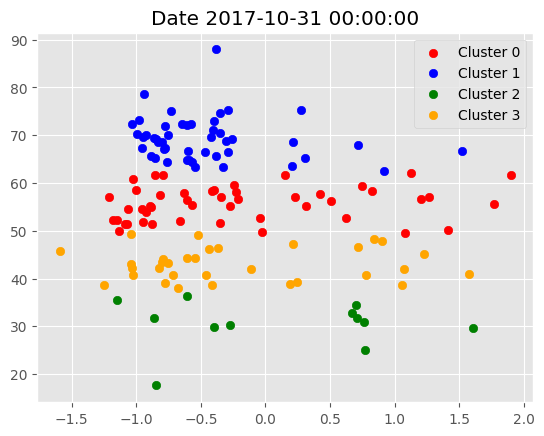

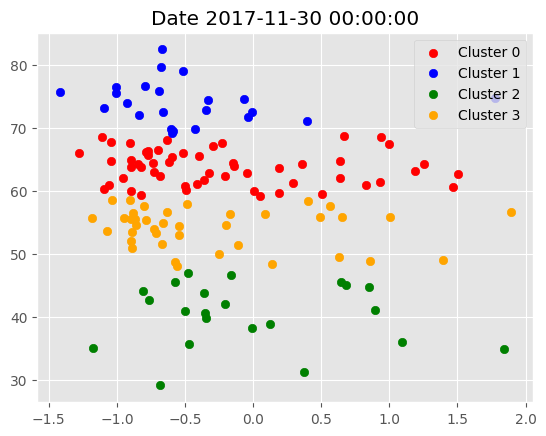

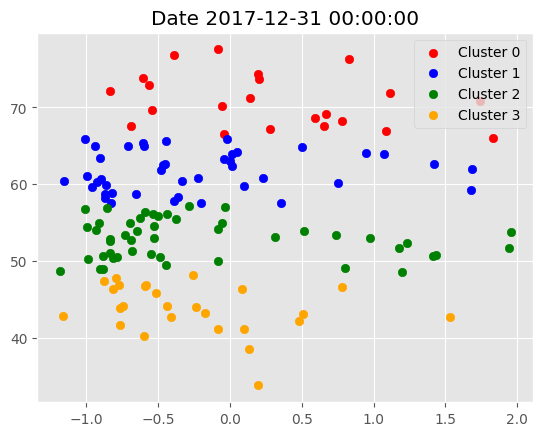

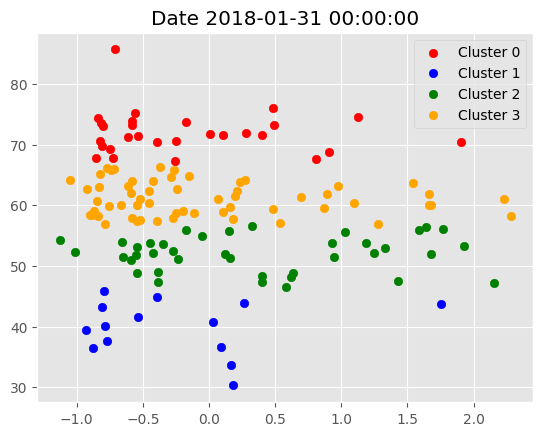

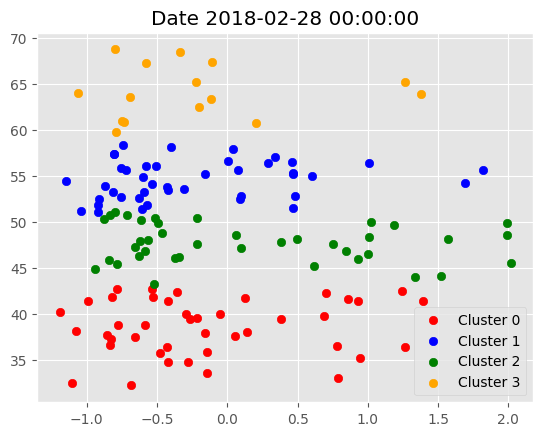

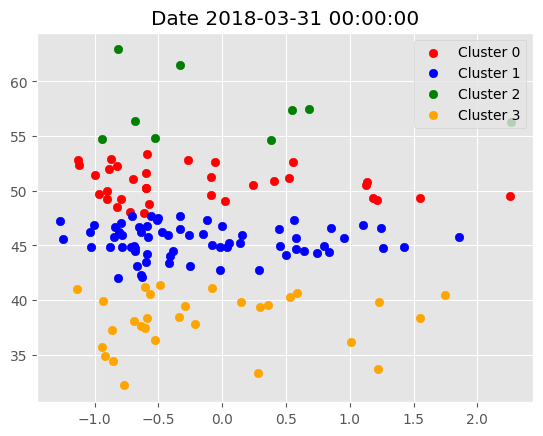

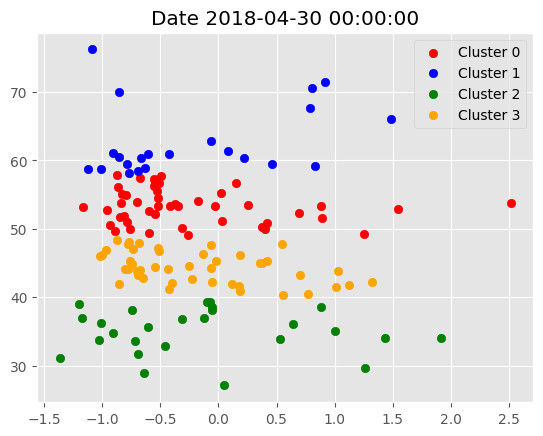

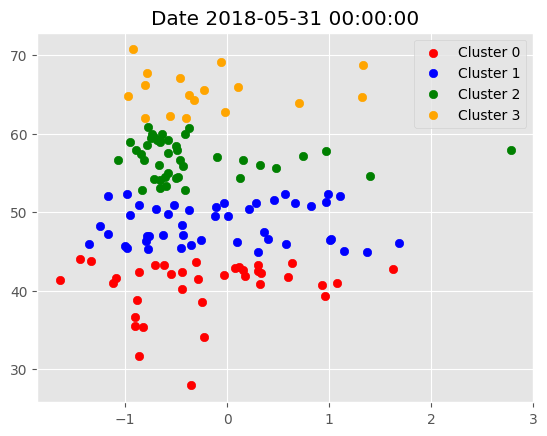

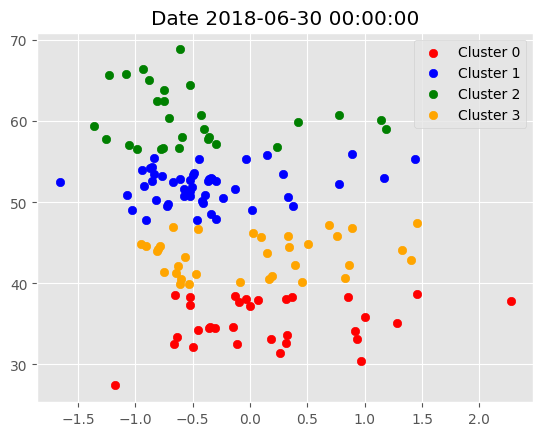

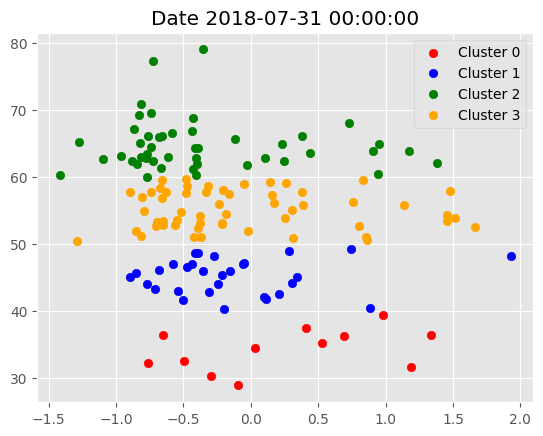

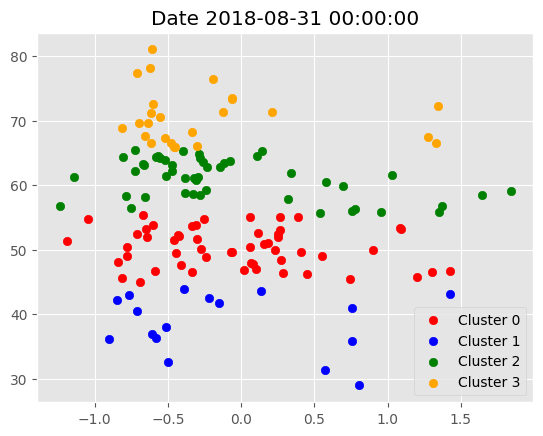

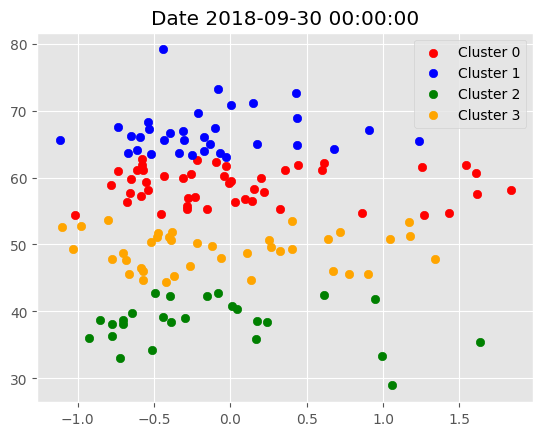

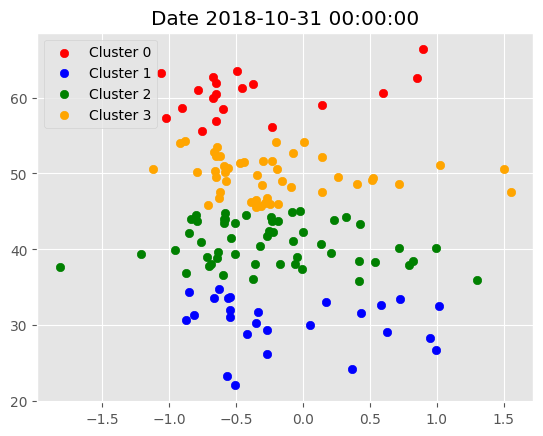

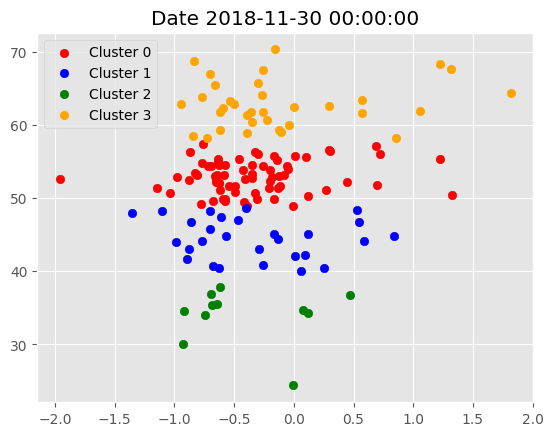

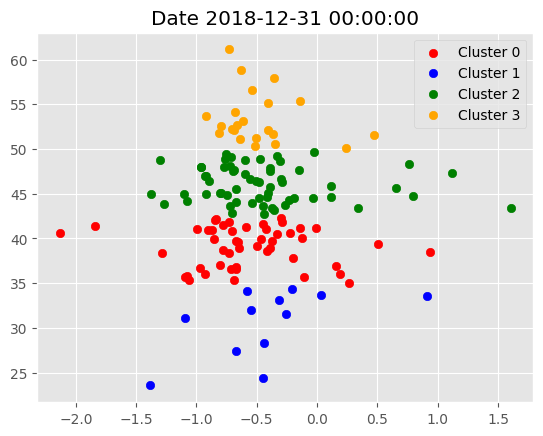

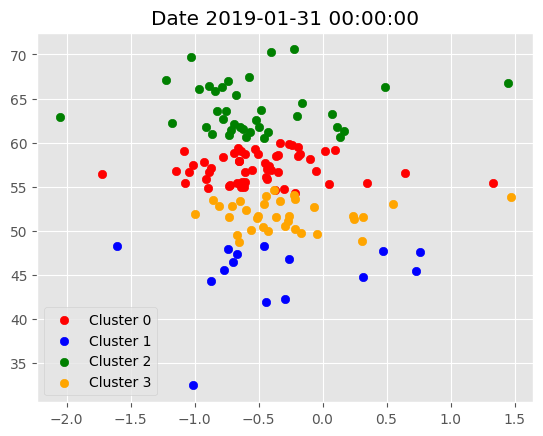

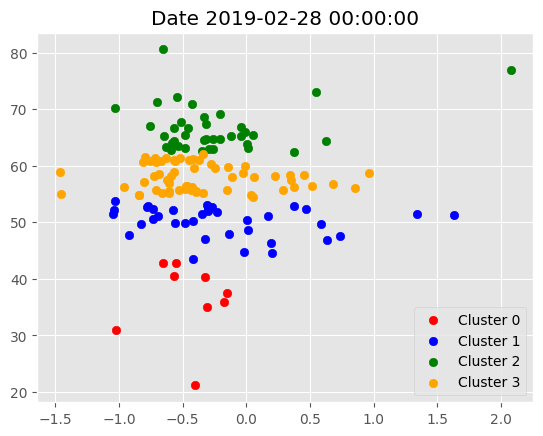

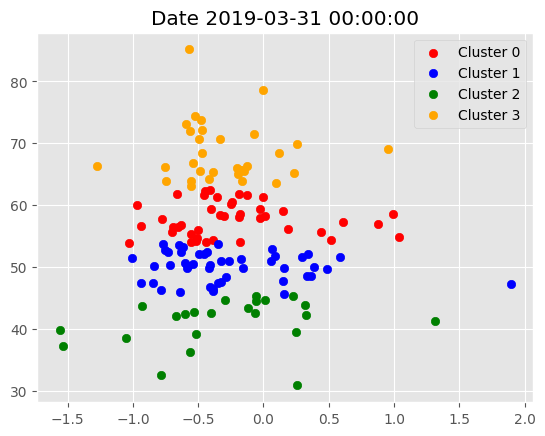

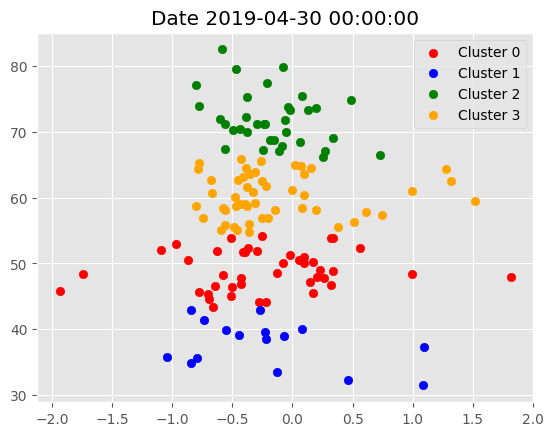

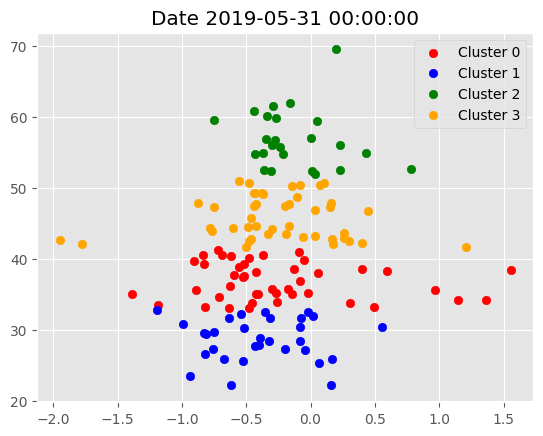

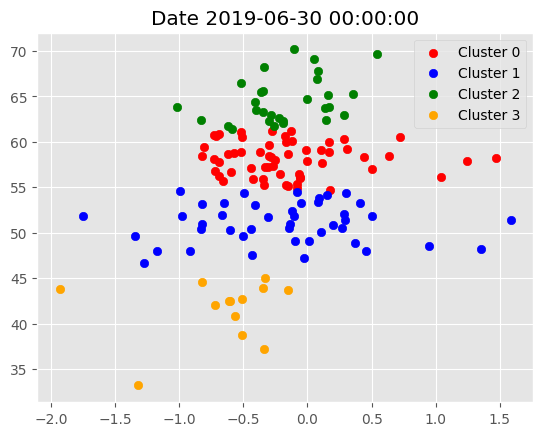

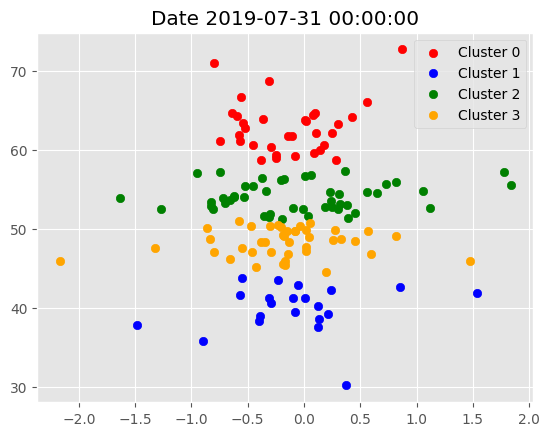

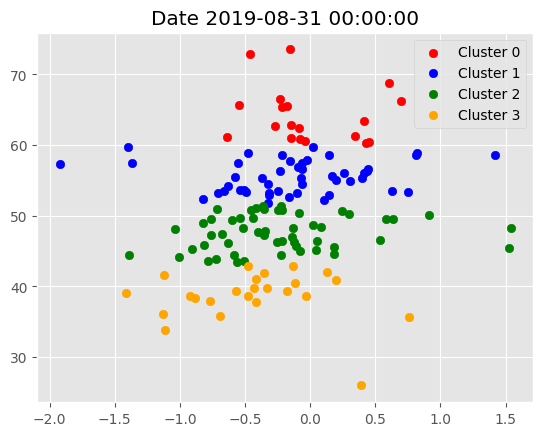

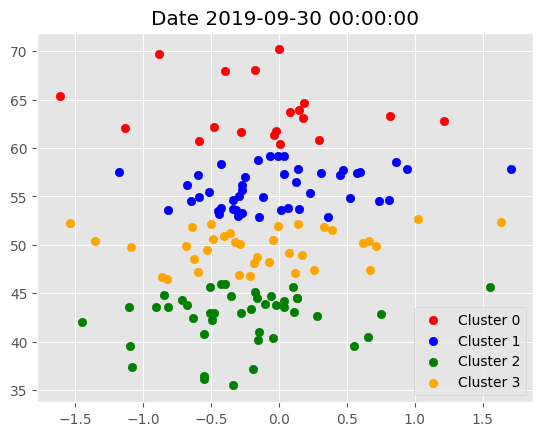

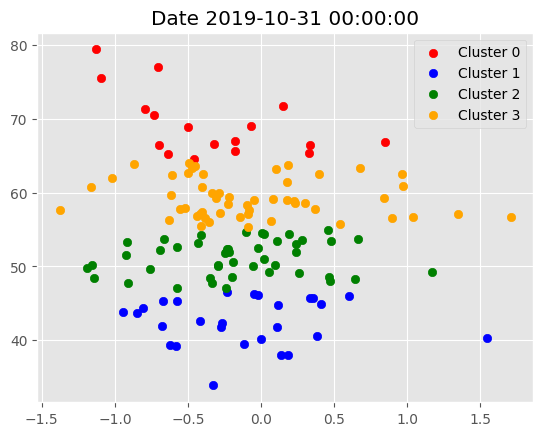

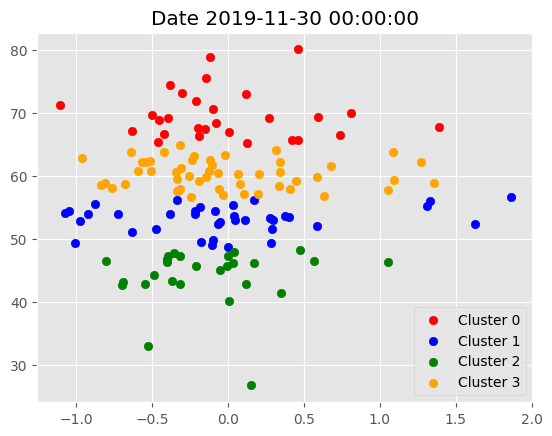

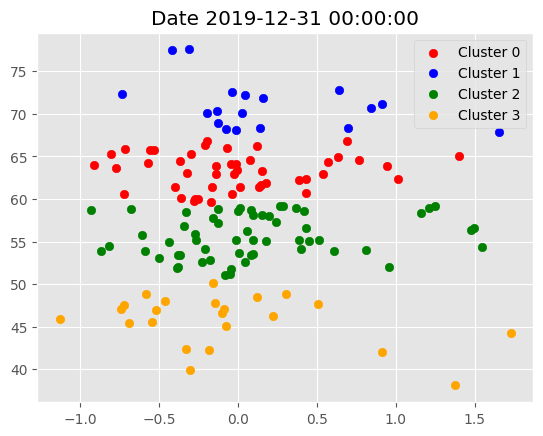

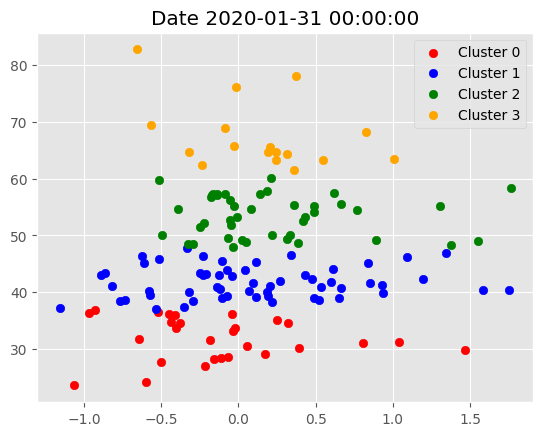

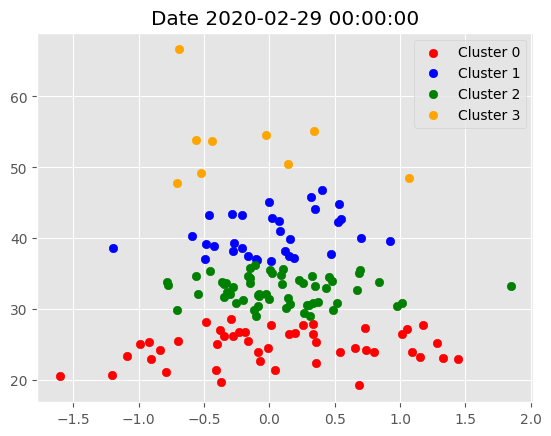

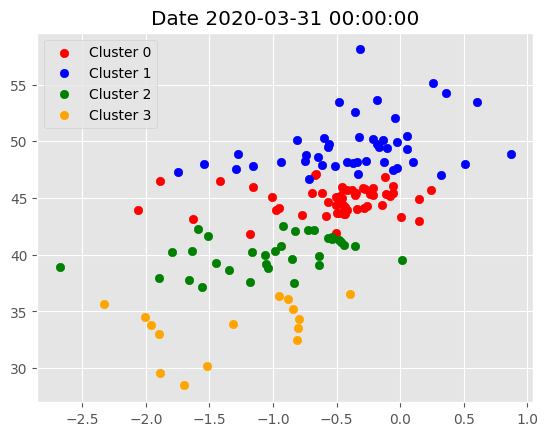

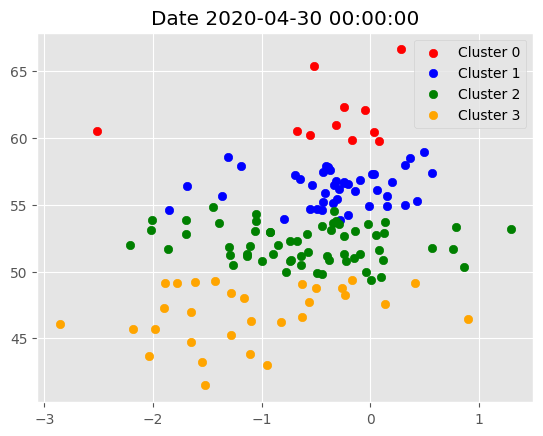

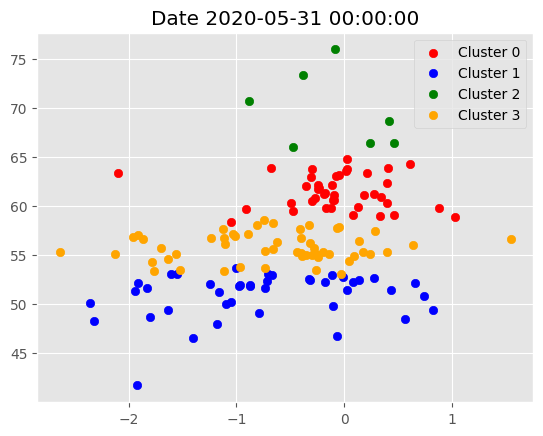

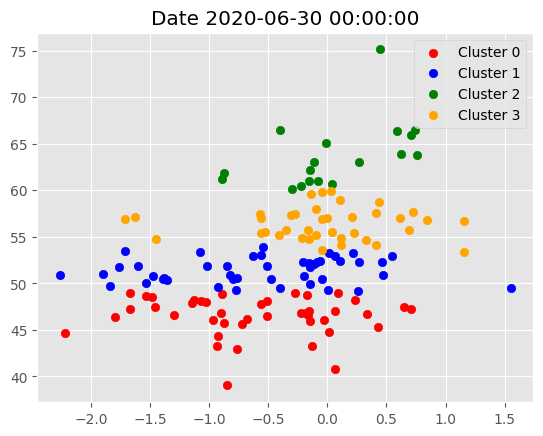

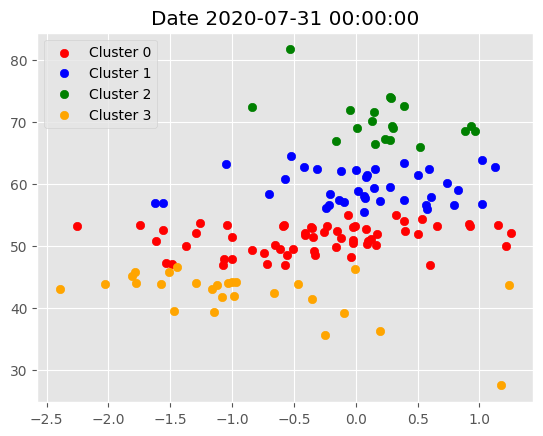

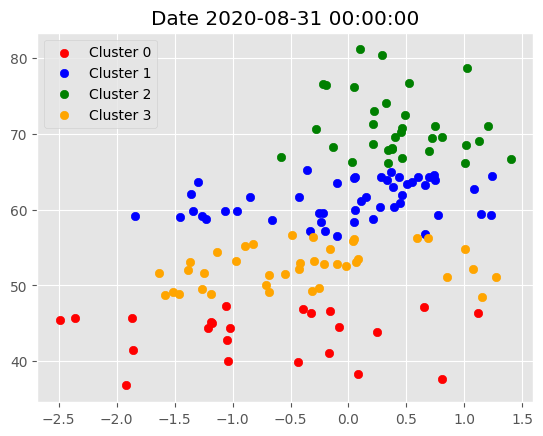

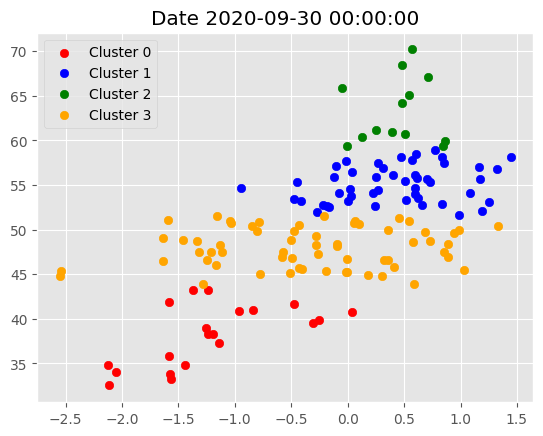

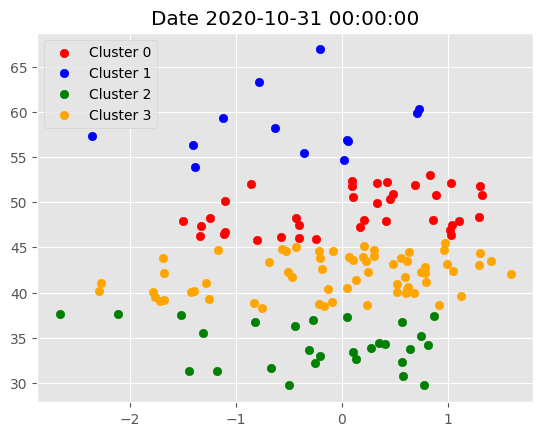

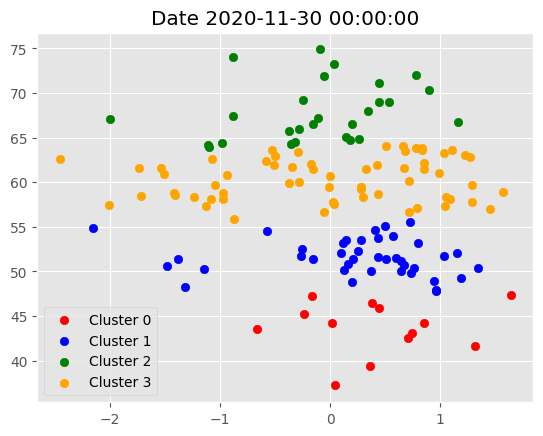

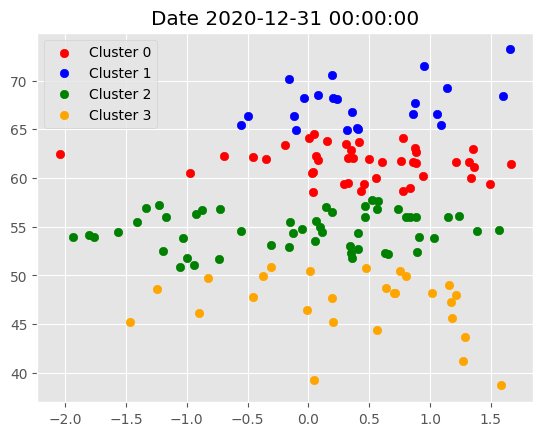

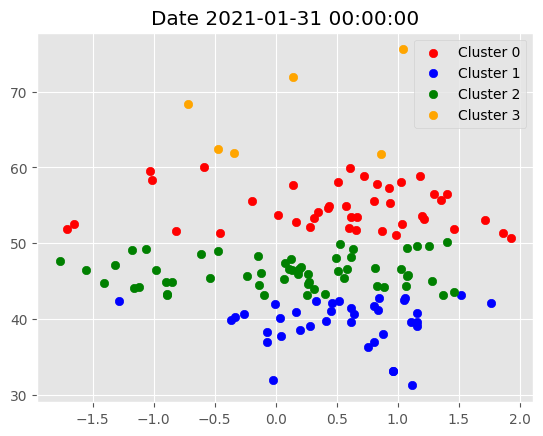

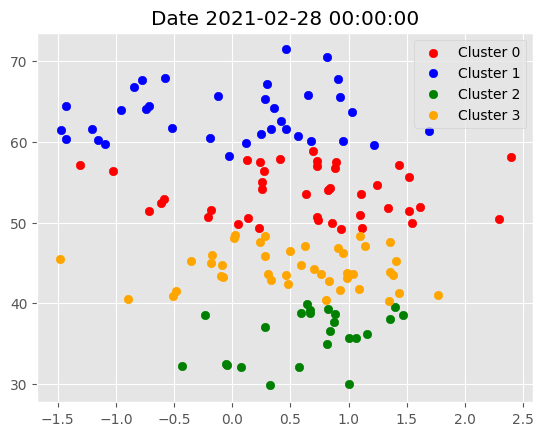

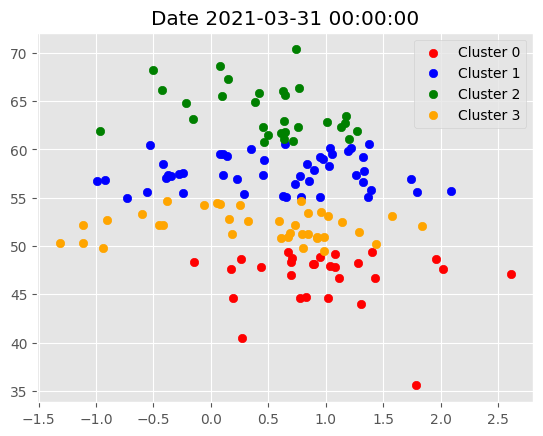

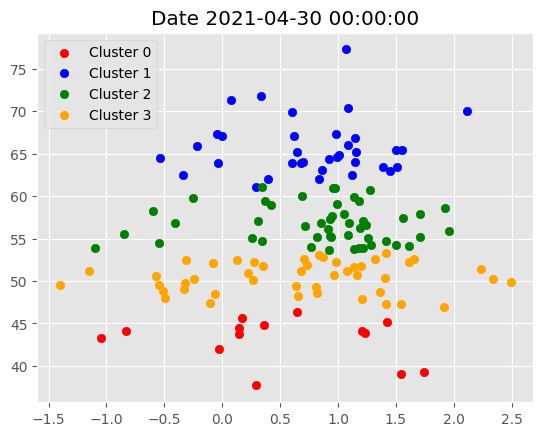

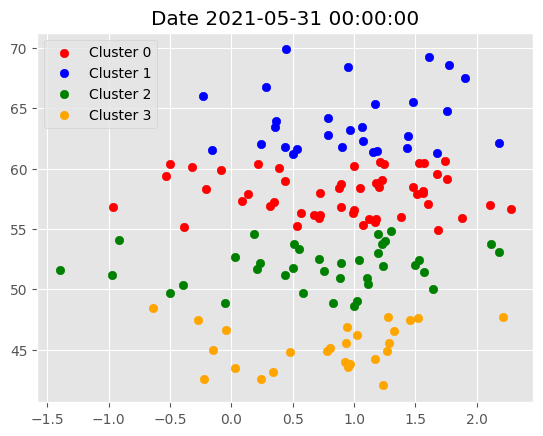

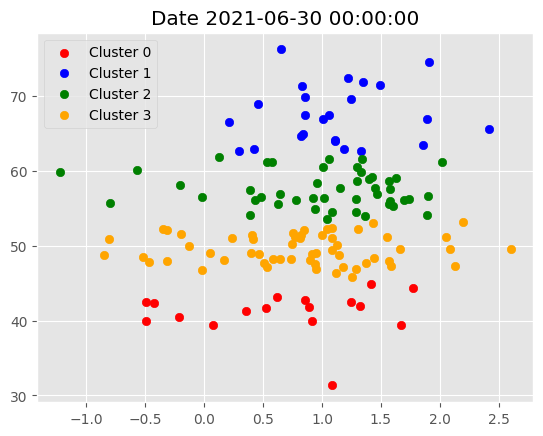

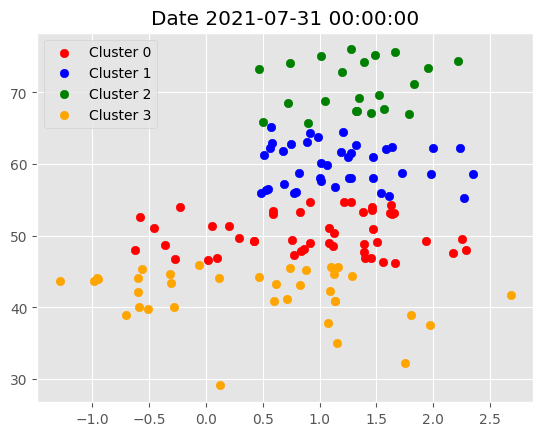

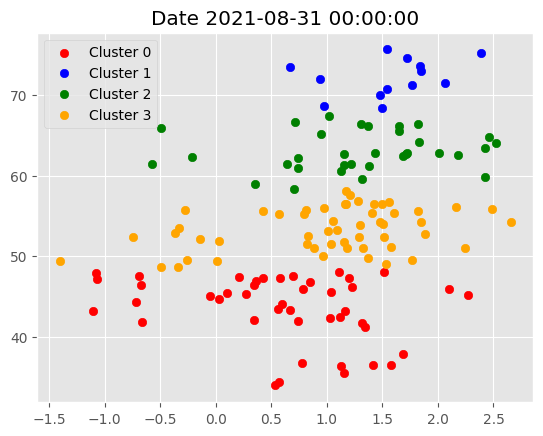

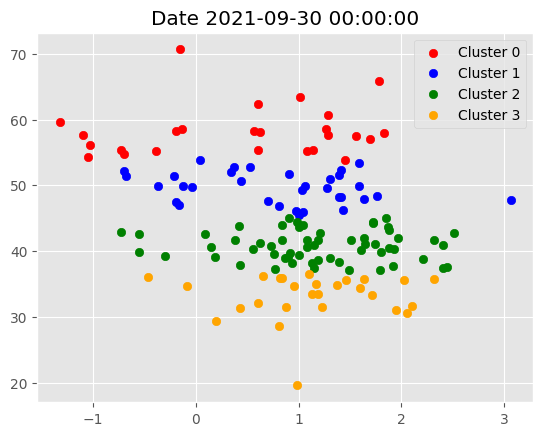

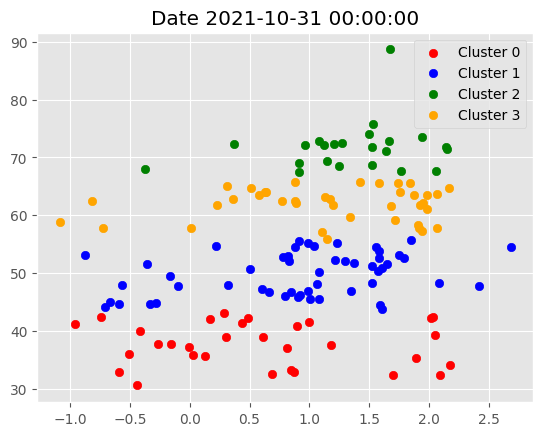

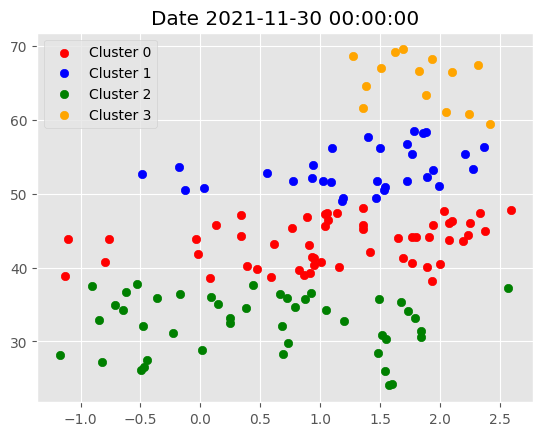

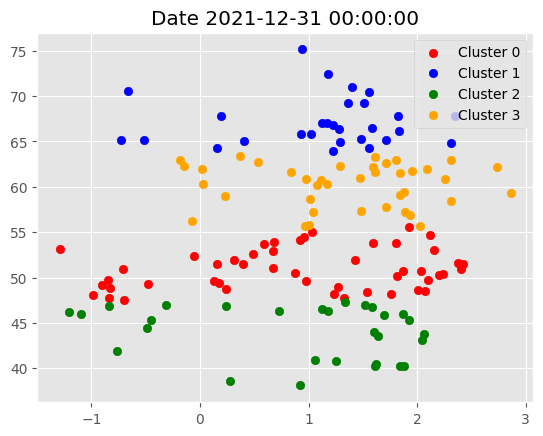

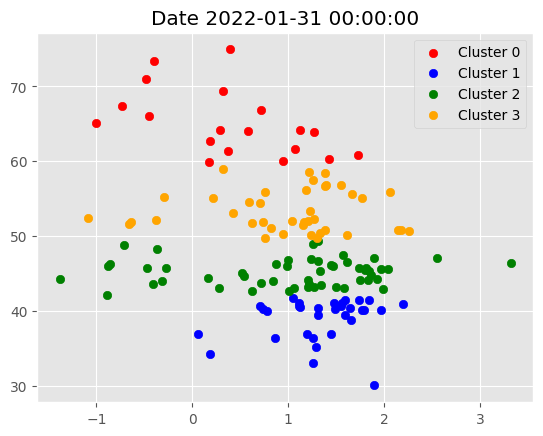

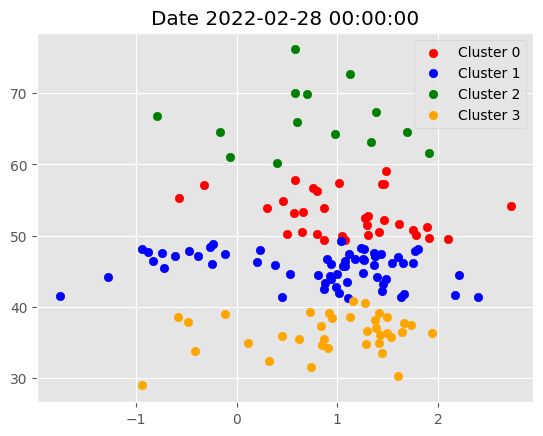

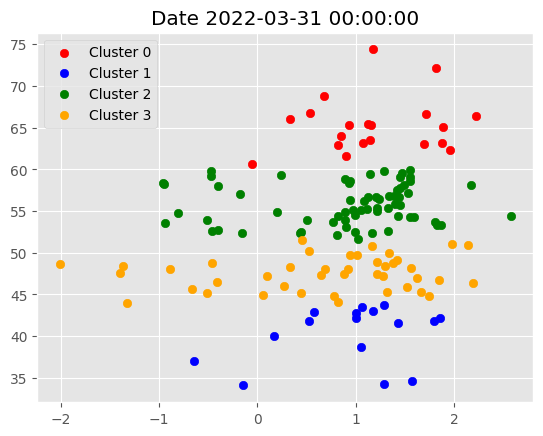

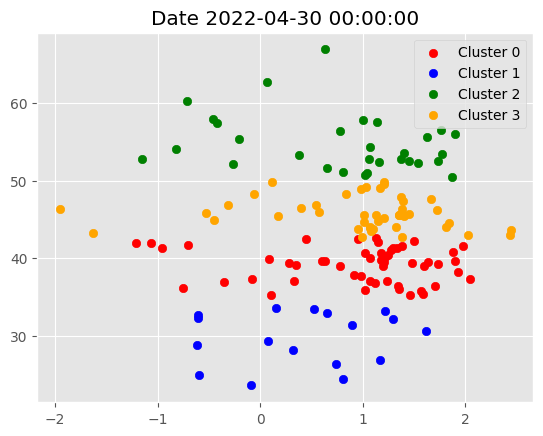

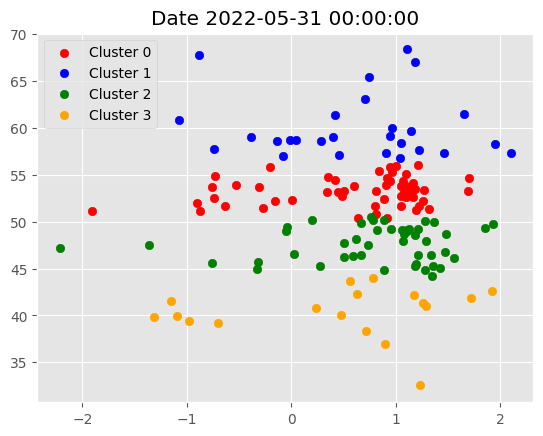

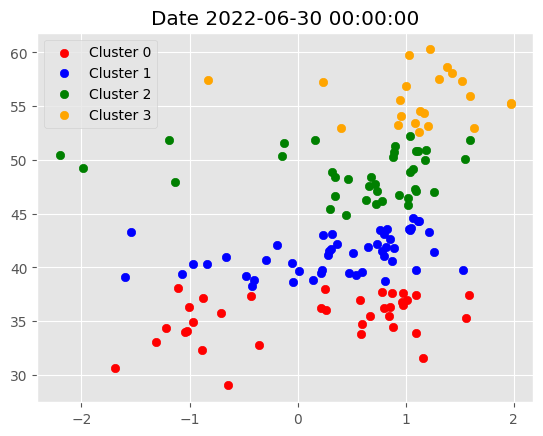

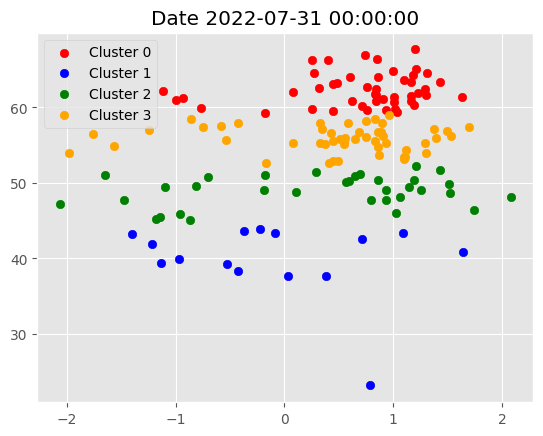

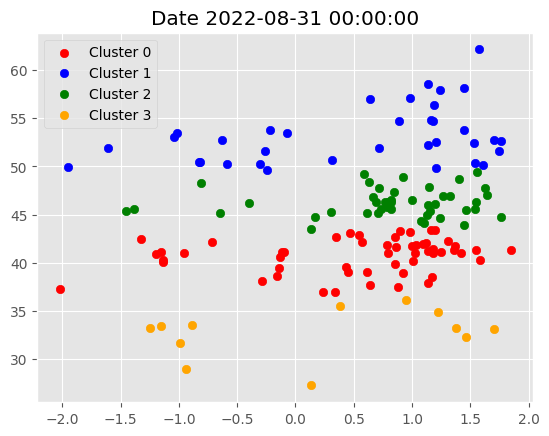

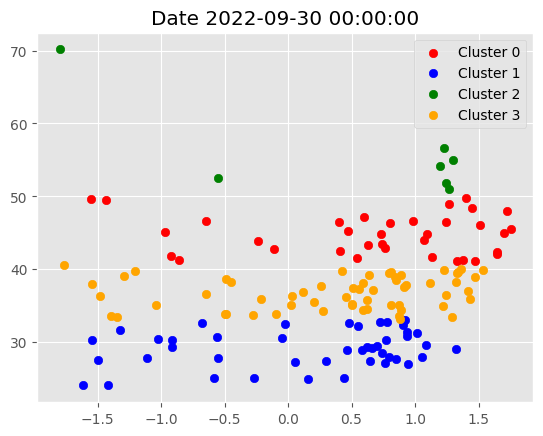

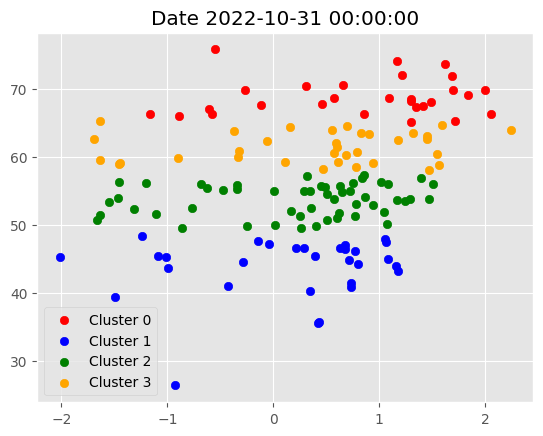

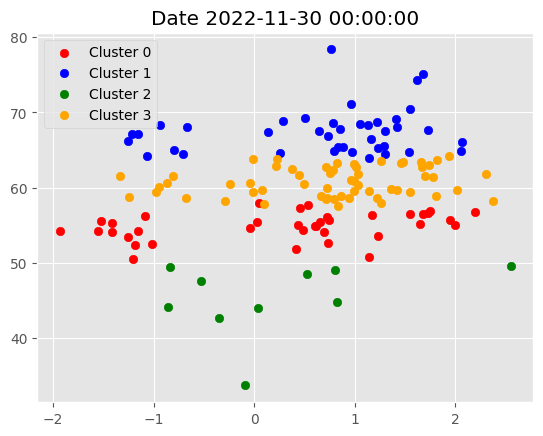

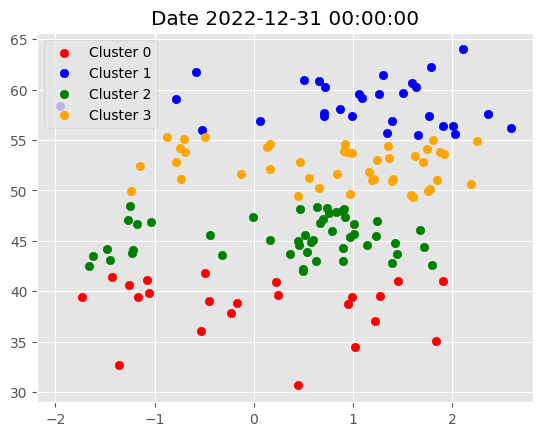

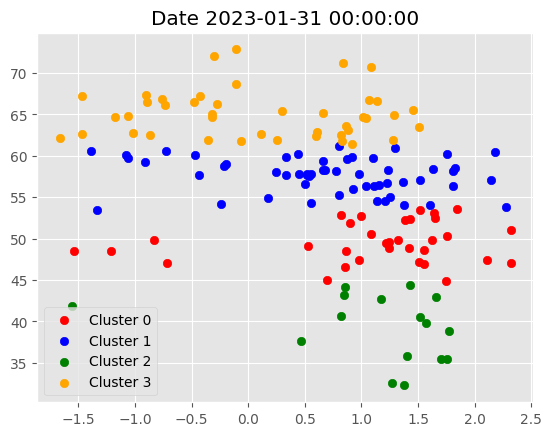

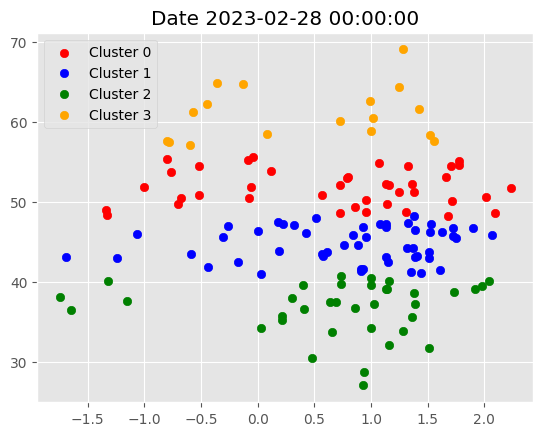

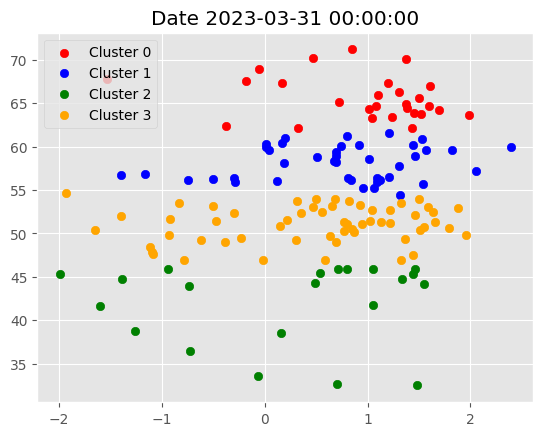

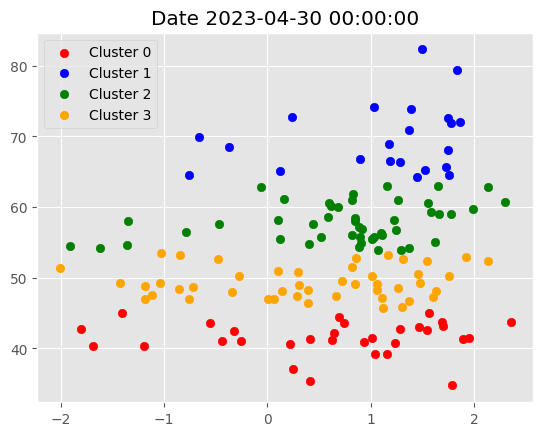

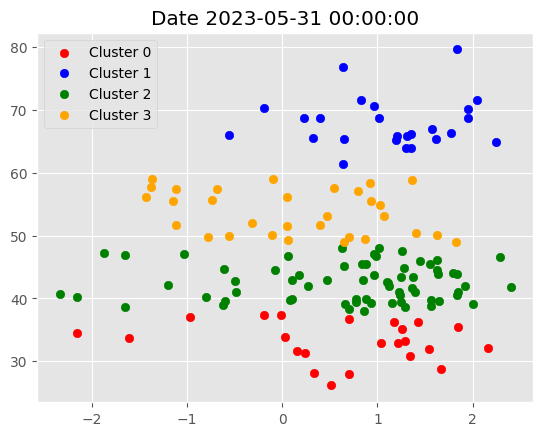

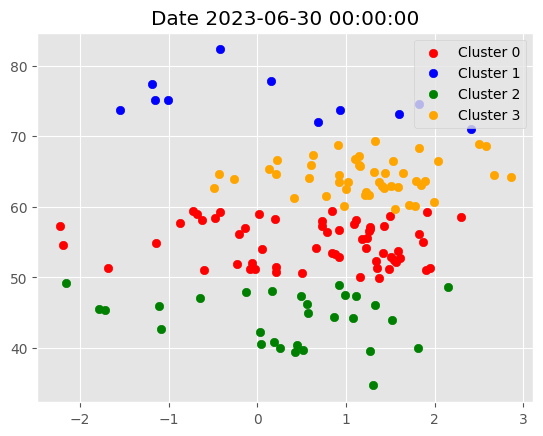

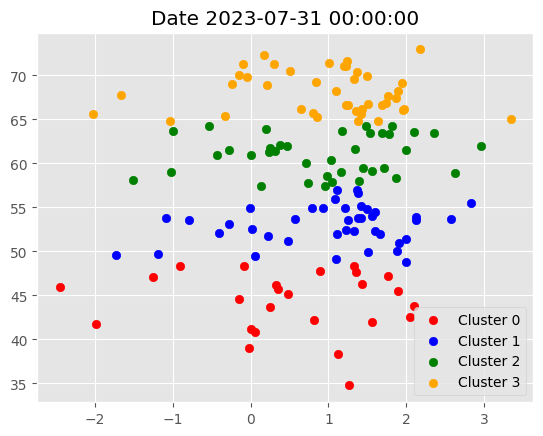

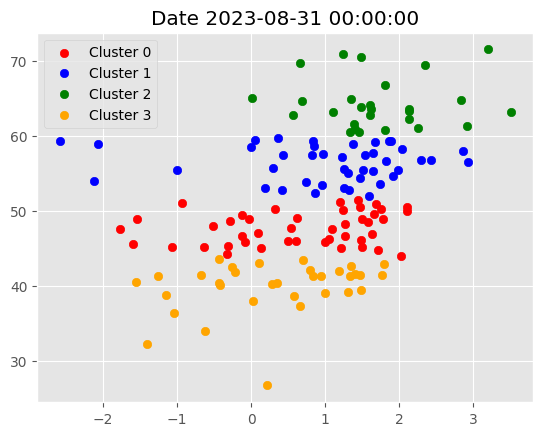

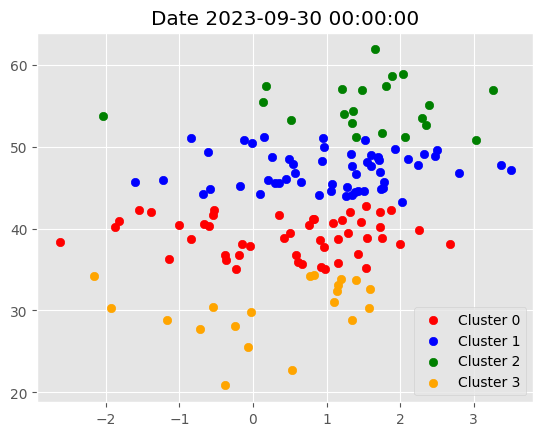

In [104]:
plt.style.use('ggplot')

for i in data_df.index.get_level_values('Date').unique().tolist():
    
    g = data_df.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

Due to the random centroid initialisation the RSI zones are not captured consitently.

In [105]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

In [106]:
data_df = data_df.drop('cluster', axis=1)

def get_clusters(df):
    
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_
    
    return df

data_df = data_df.dropna().groupby('Date', group_keys=False).apply(get_clusters)


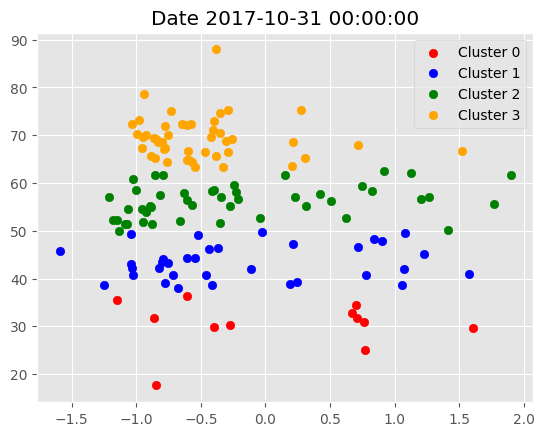

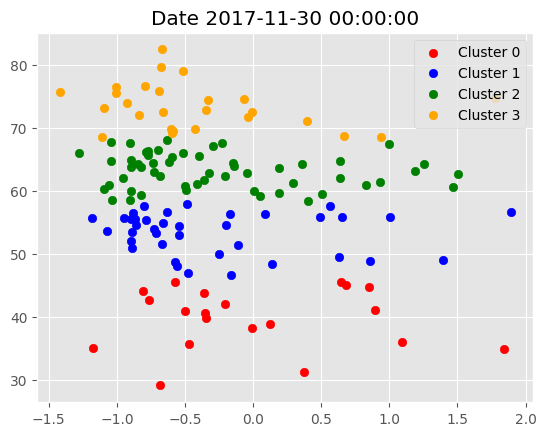

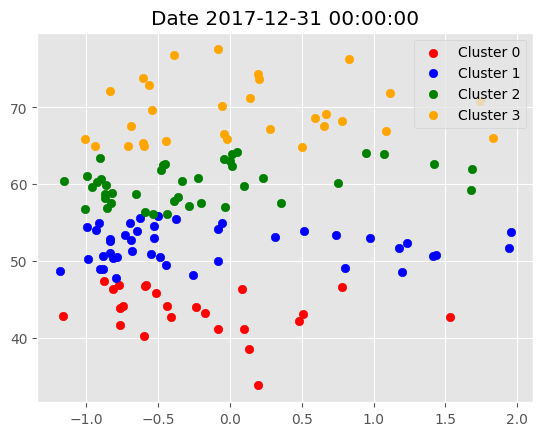

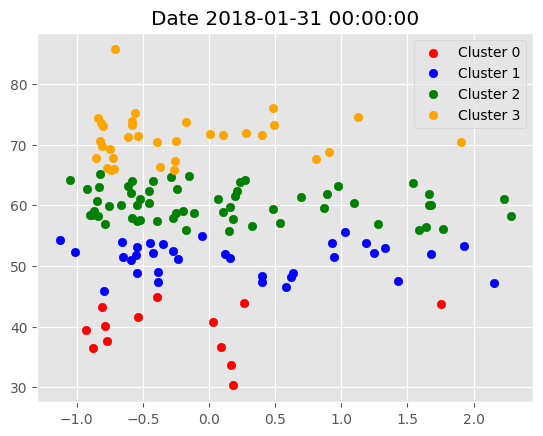

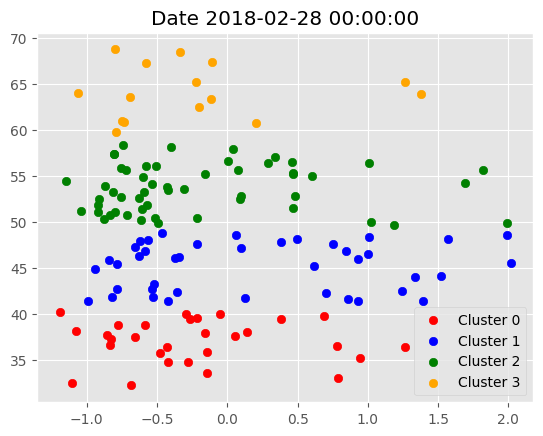

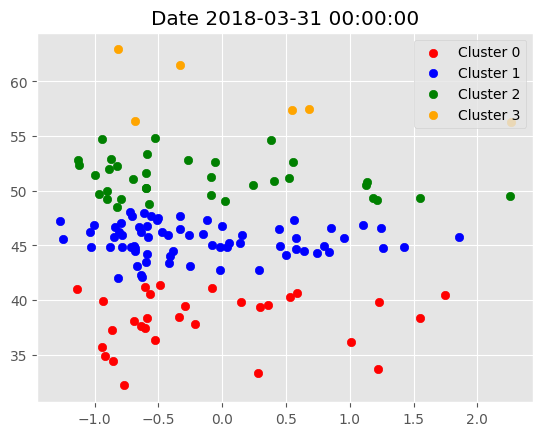

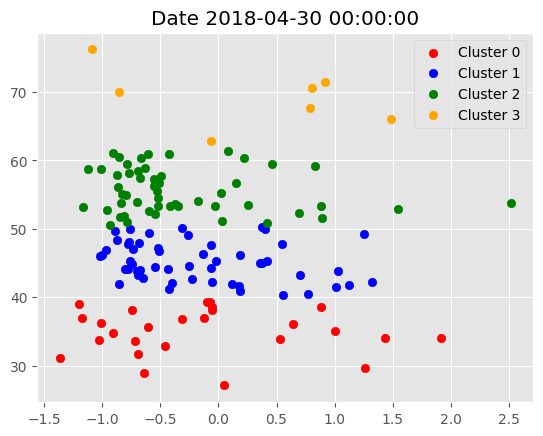

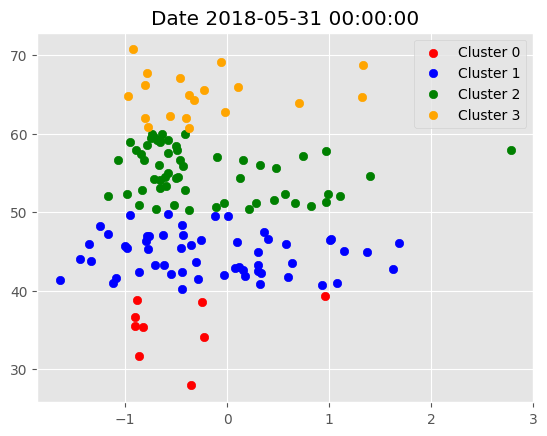

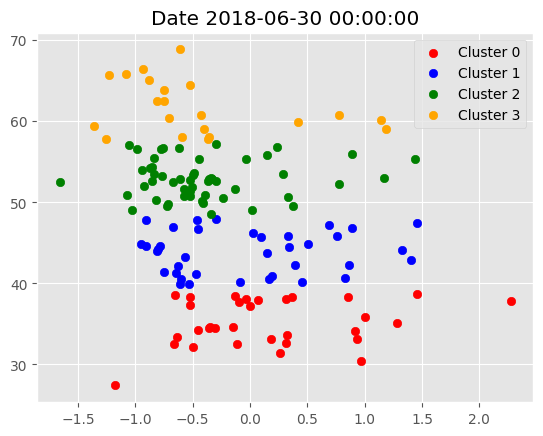

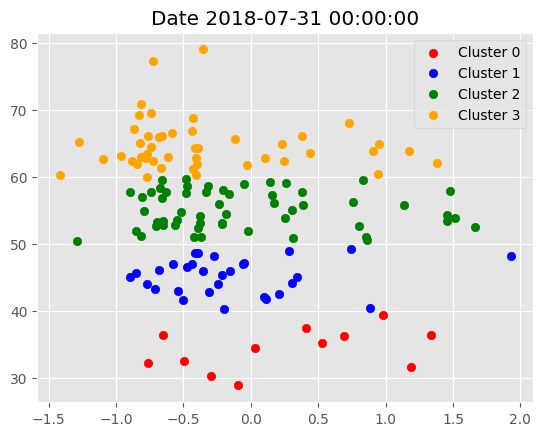

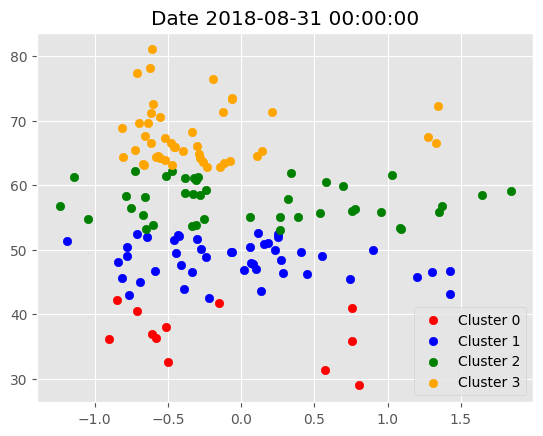

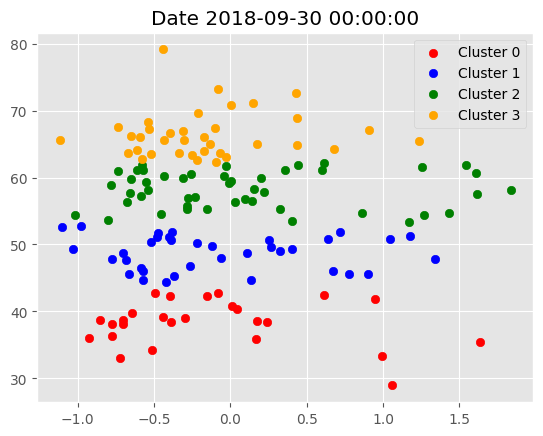

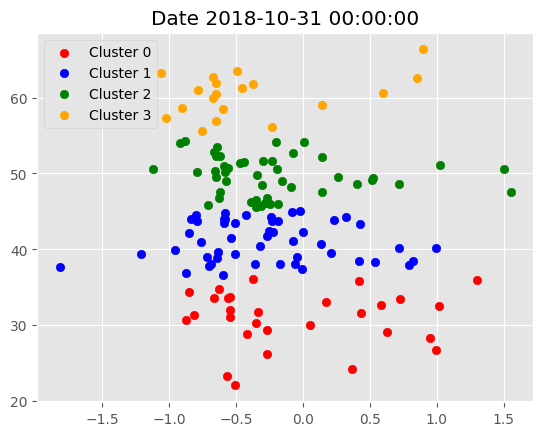

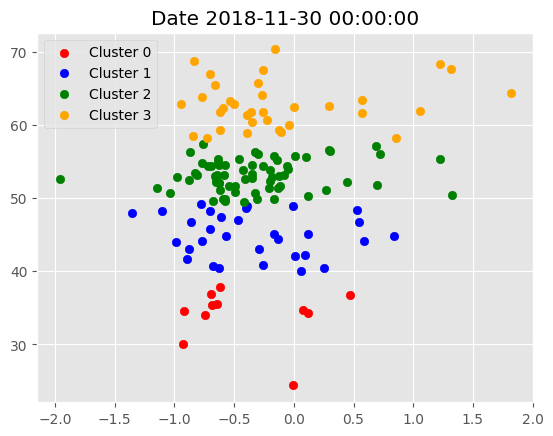

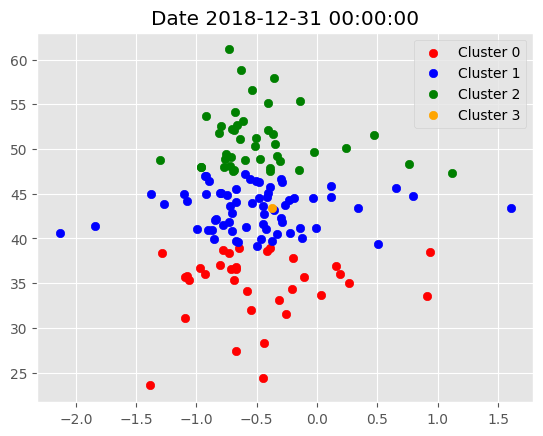

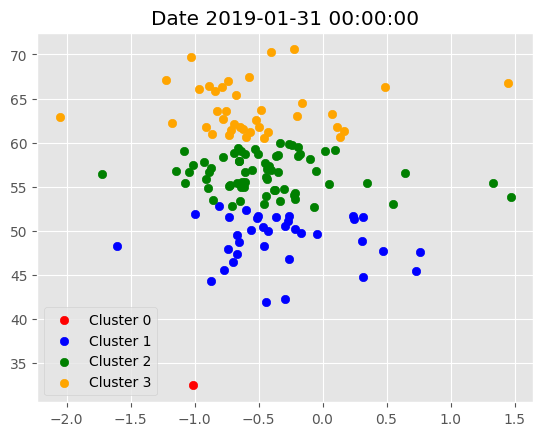

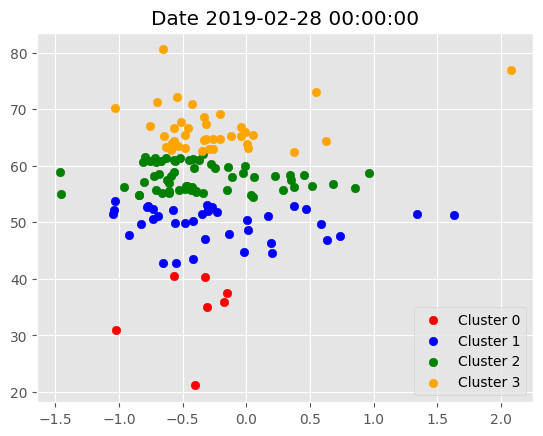

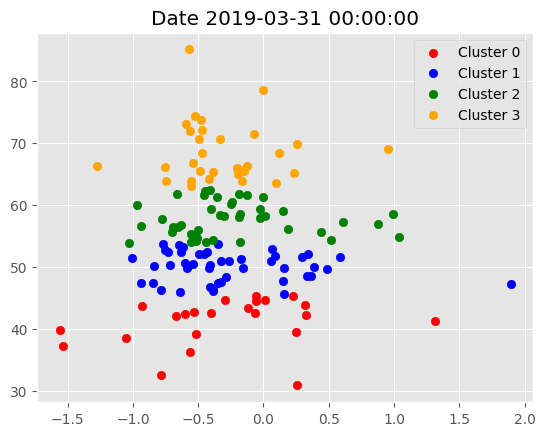

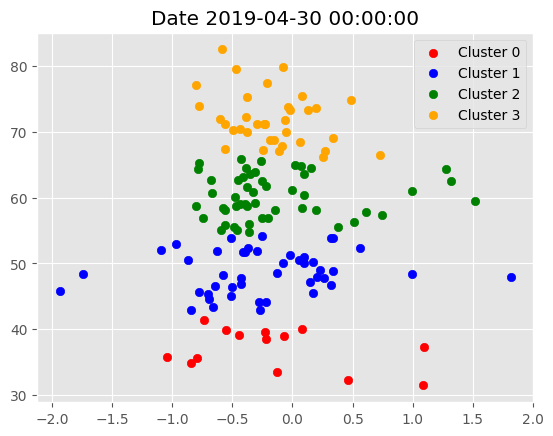

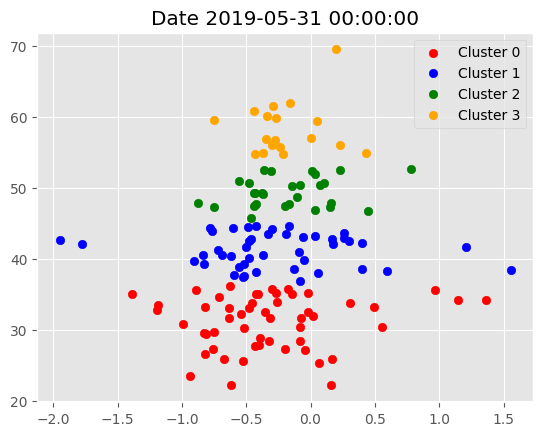

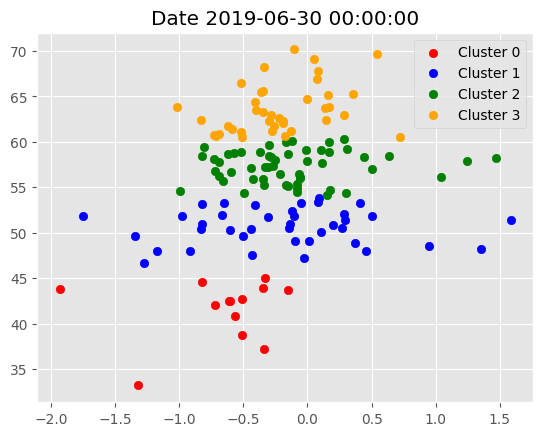

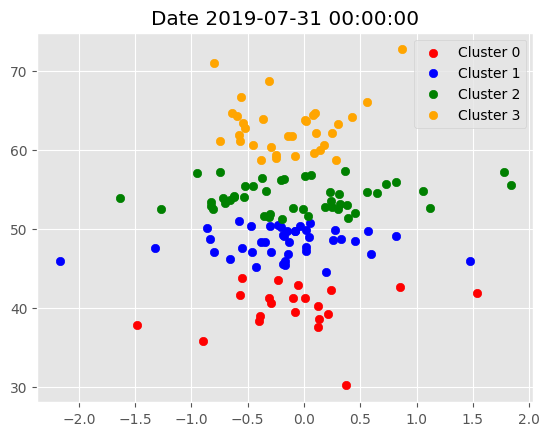

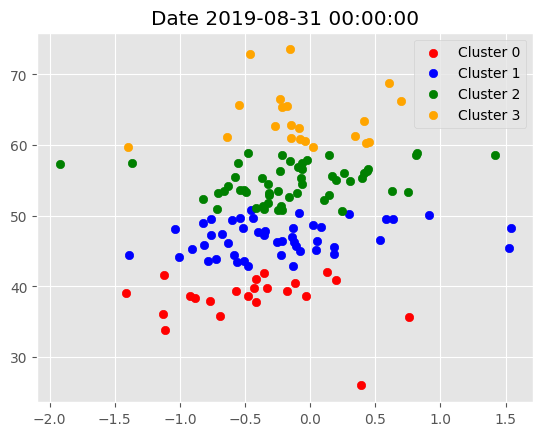

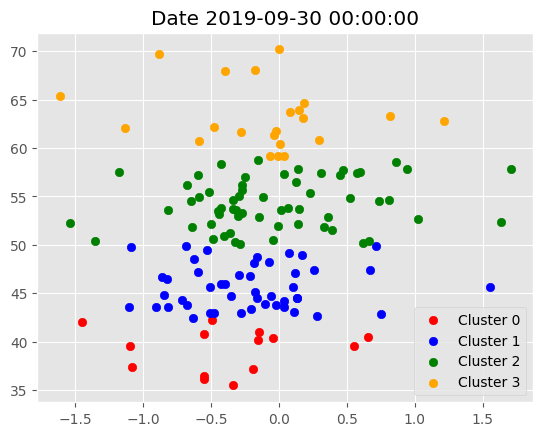

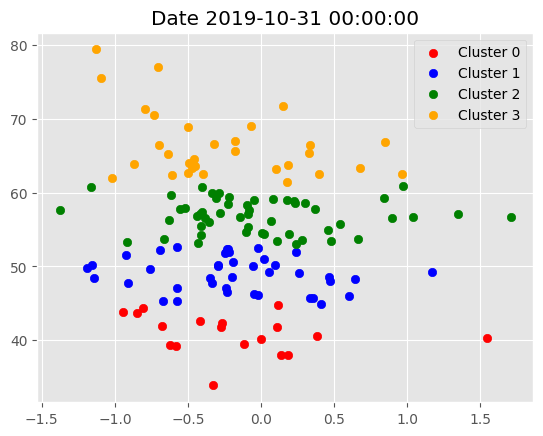

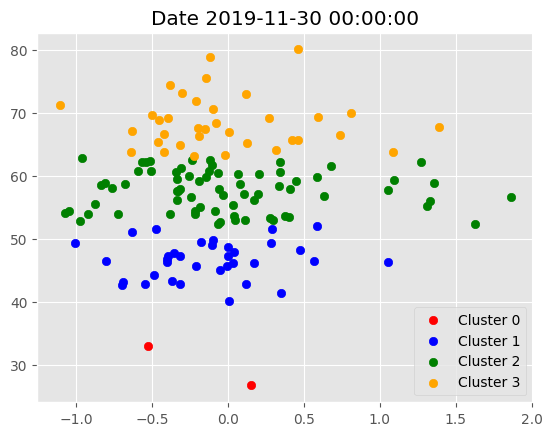

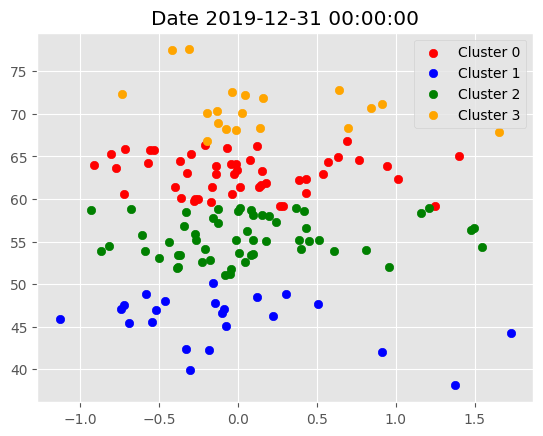

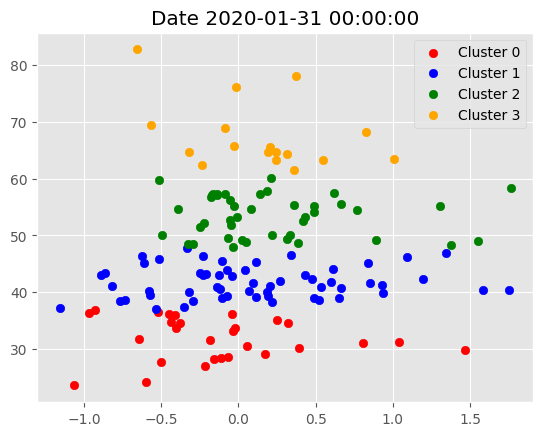

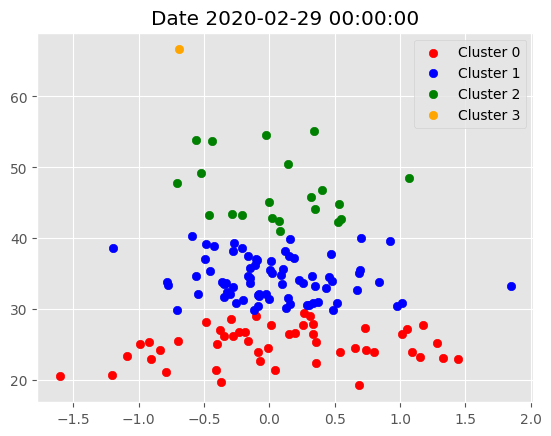

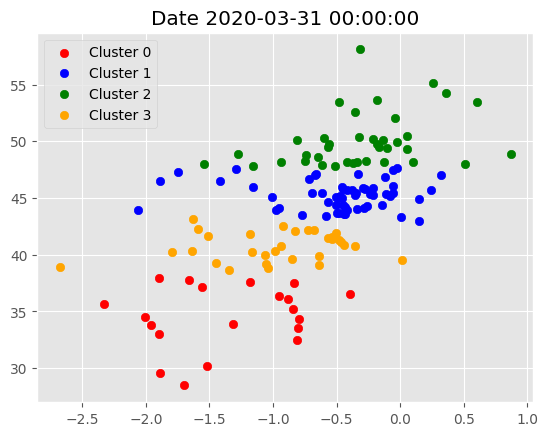

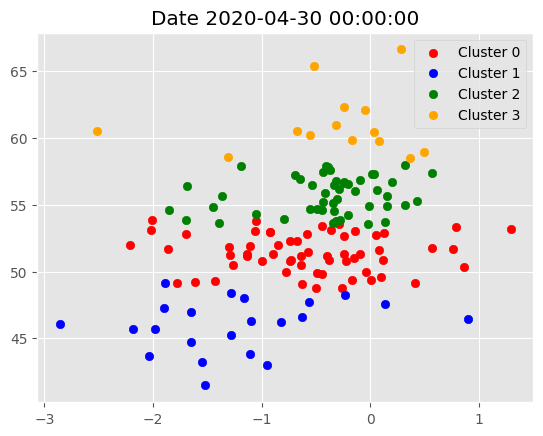

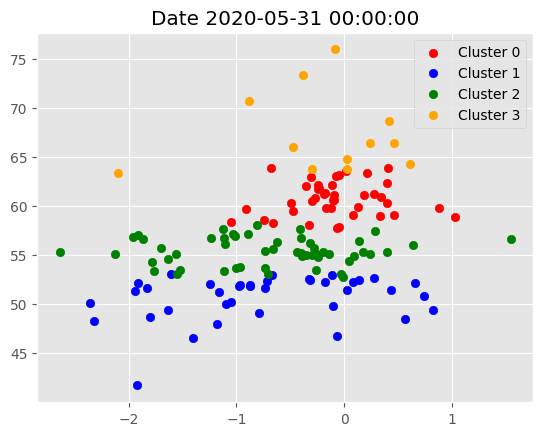

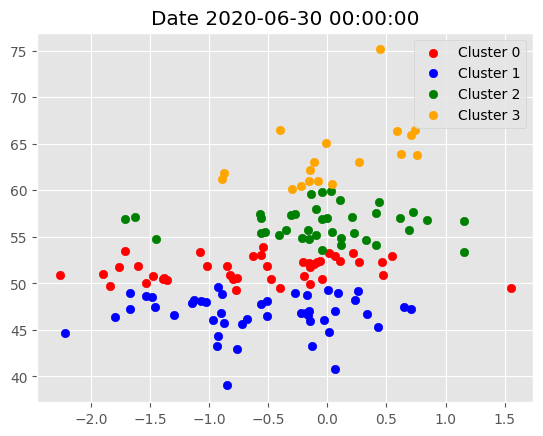

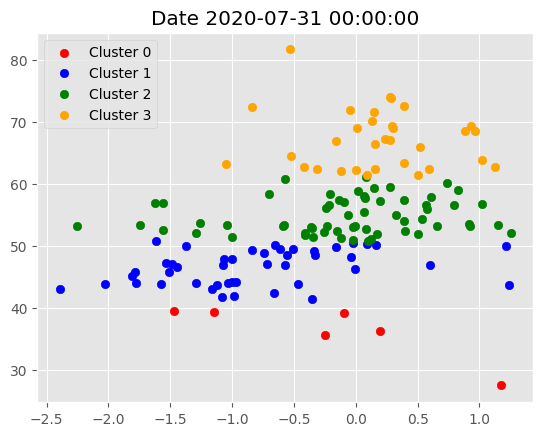

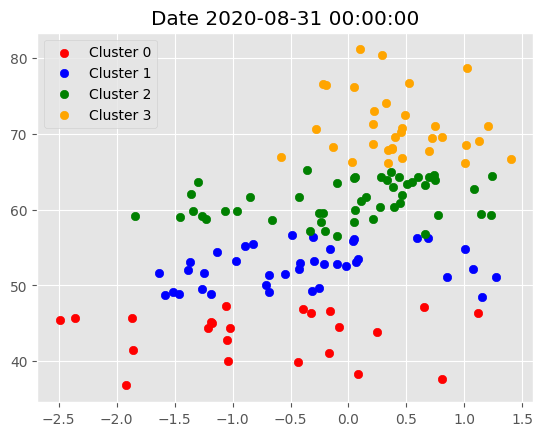

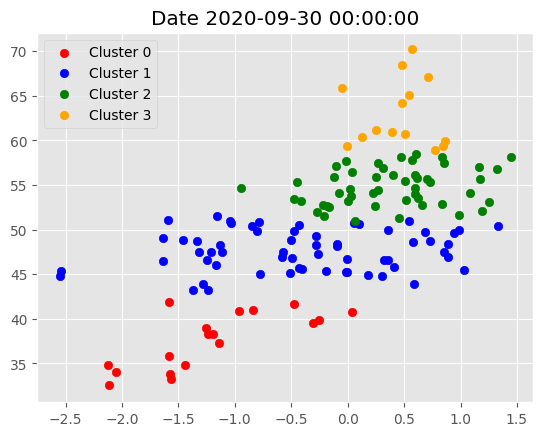

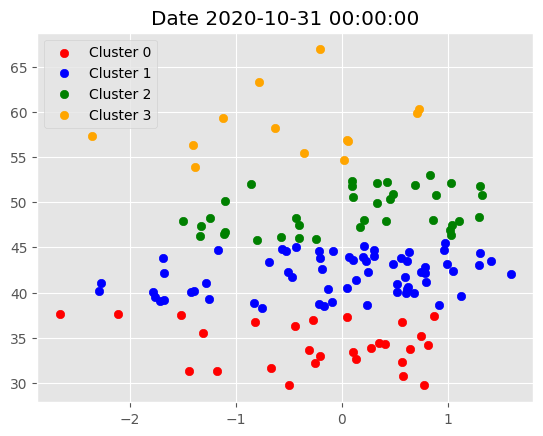

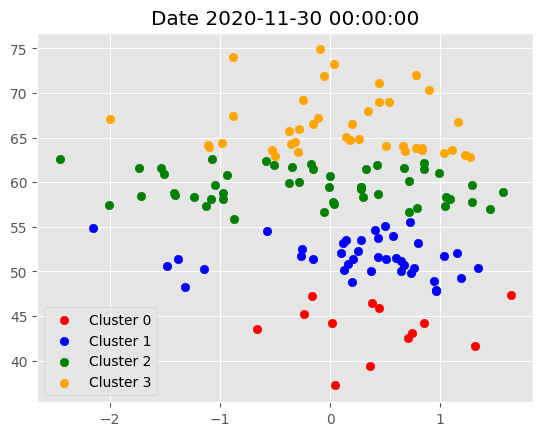

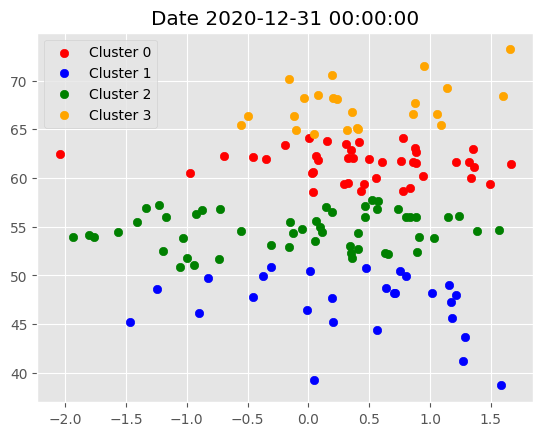

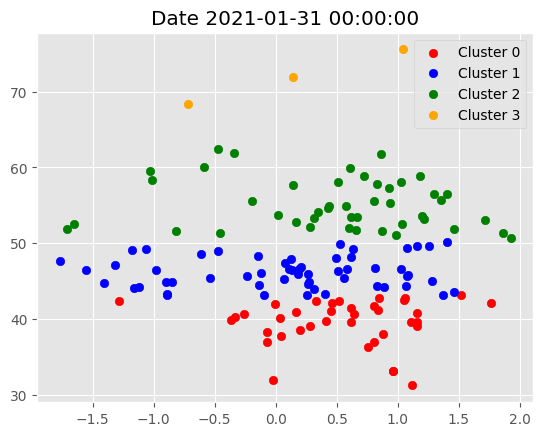

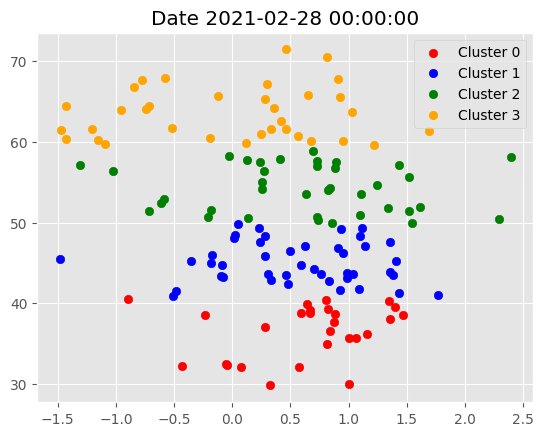

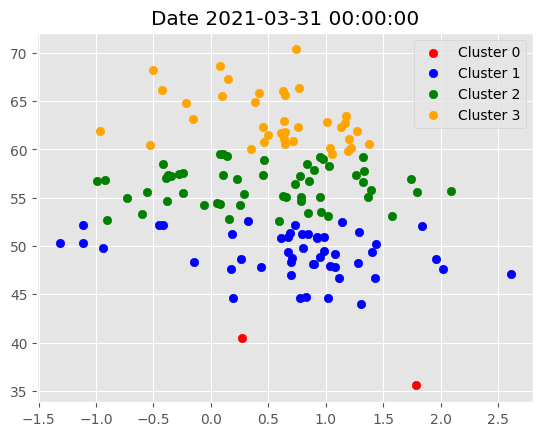

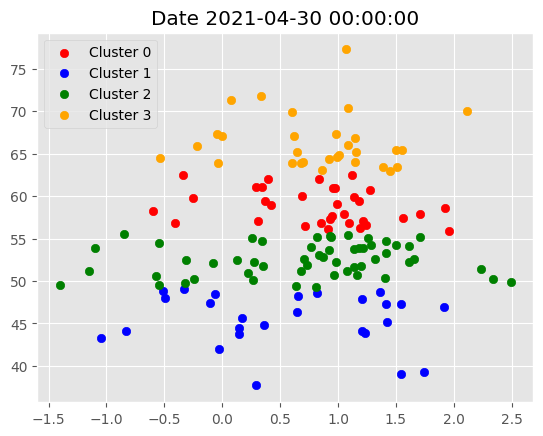

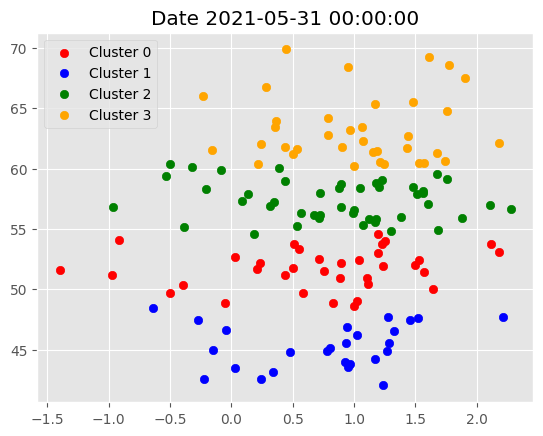

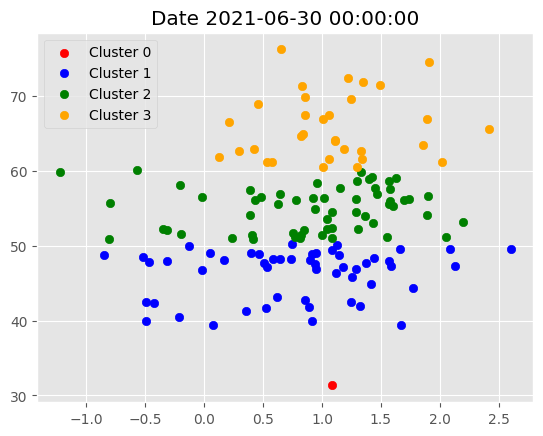

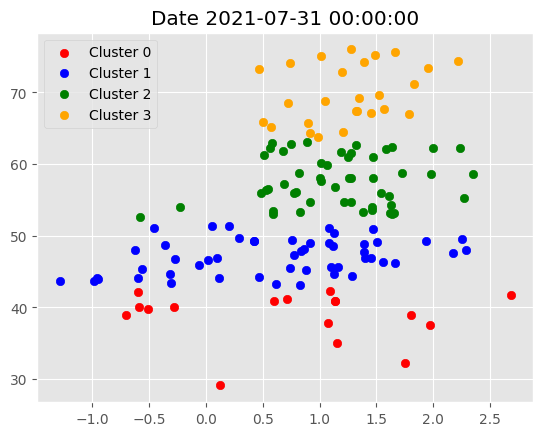

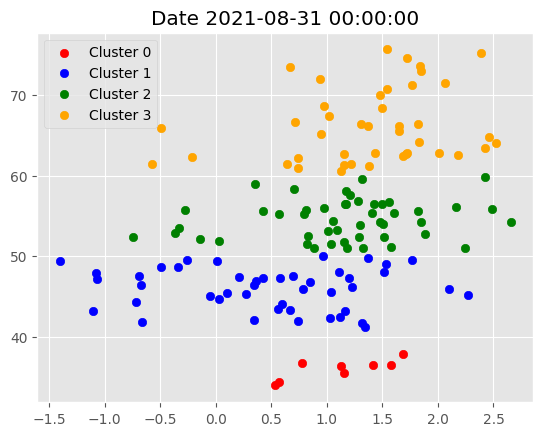

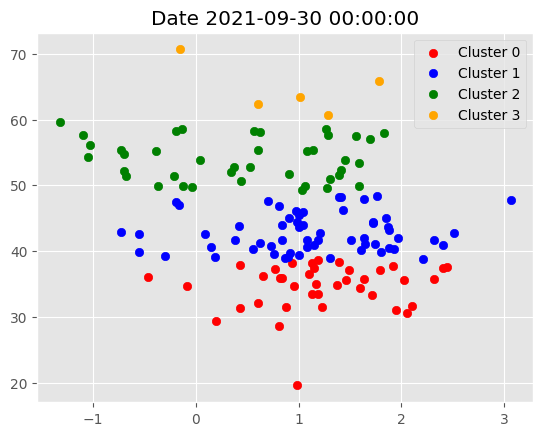

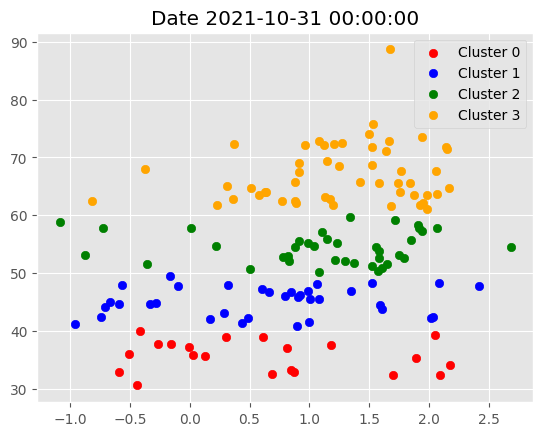

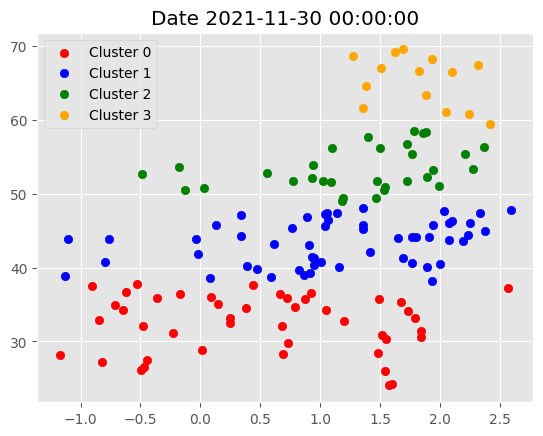

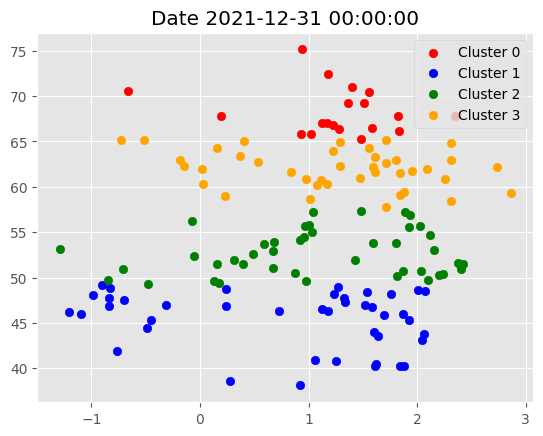

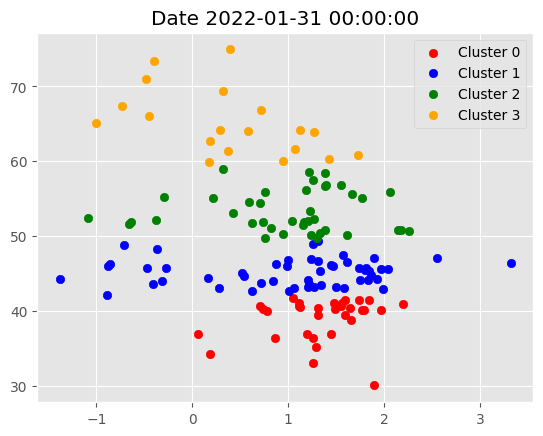

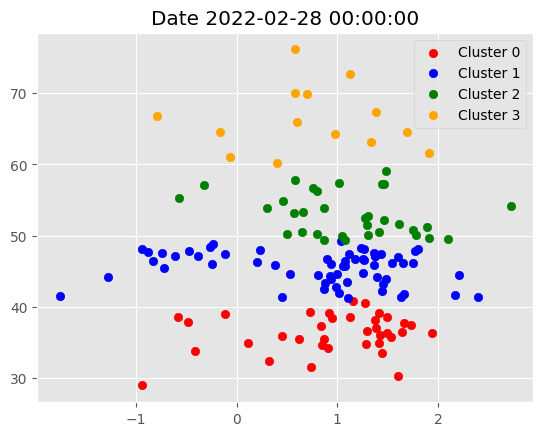

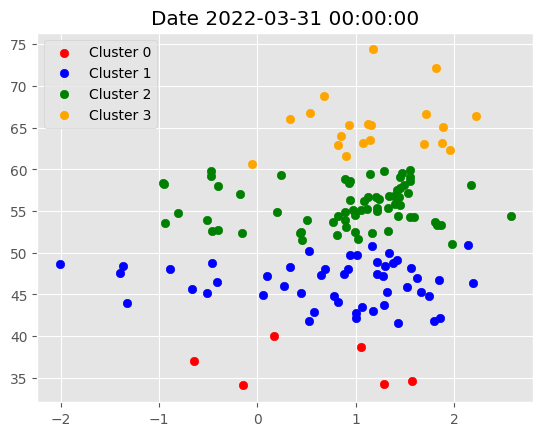

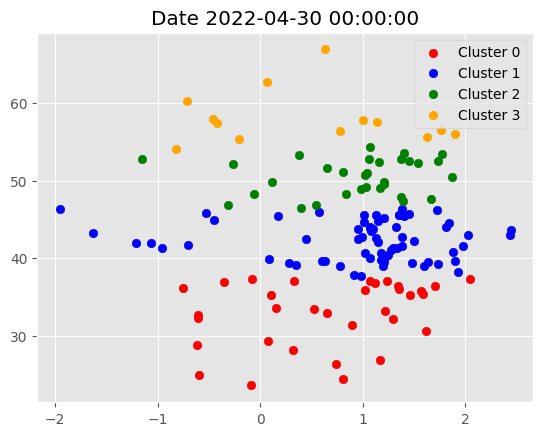

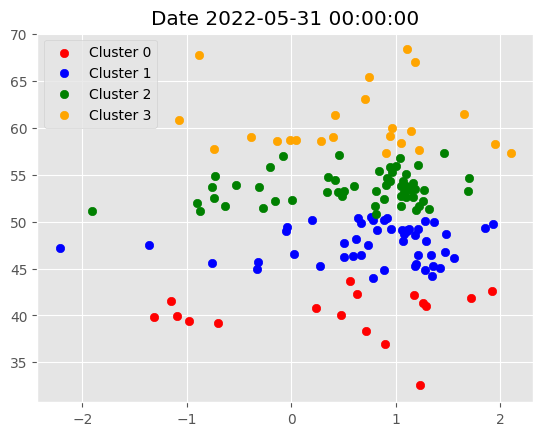

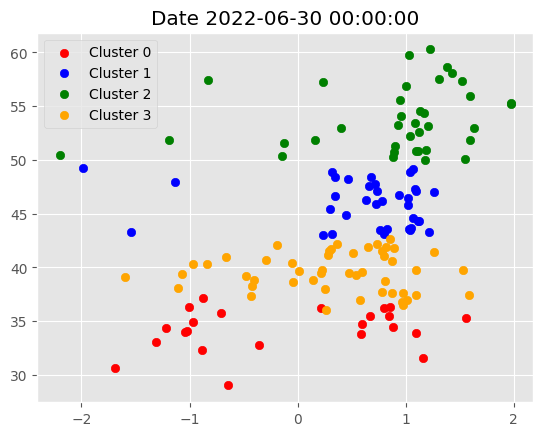

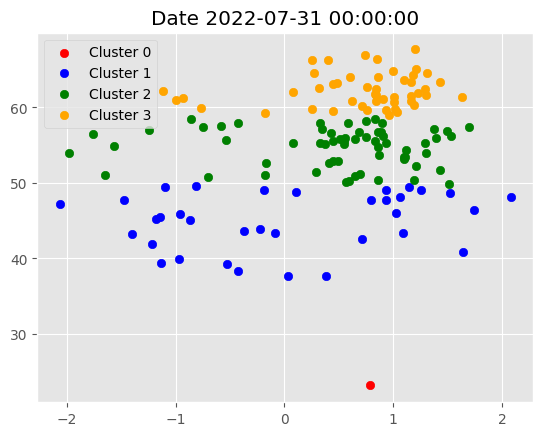

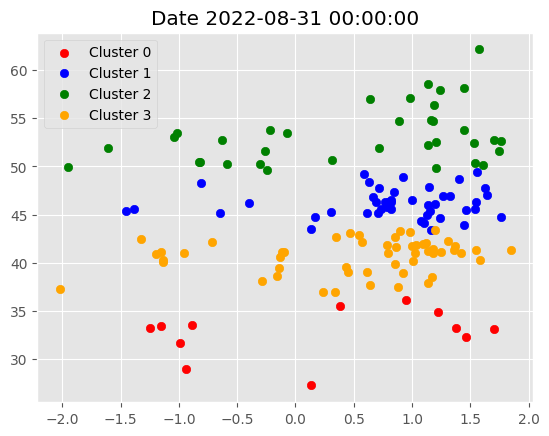

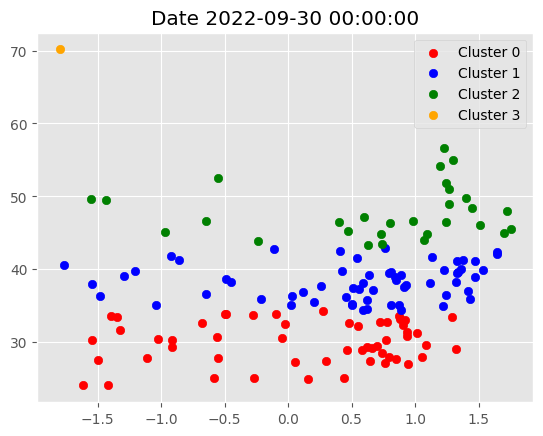

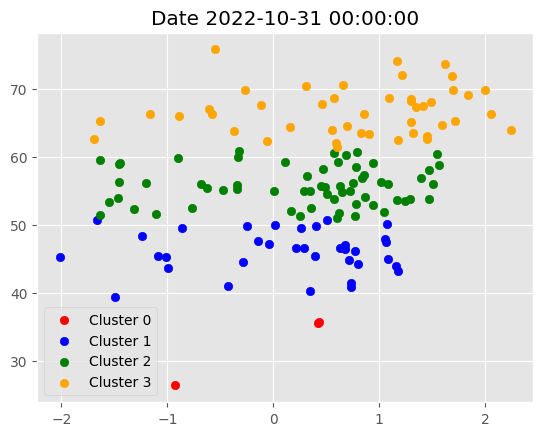

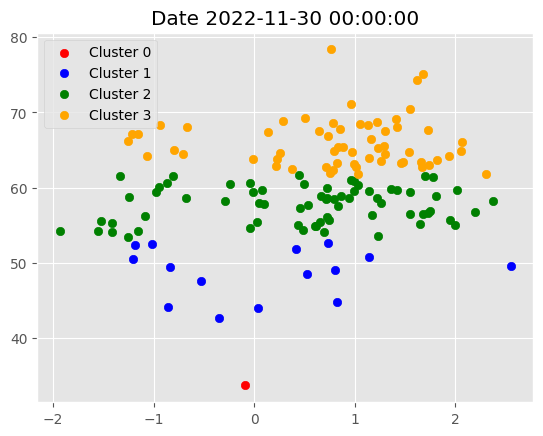

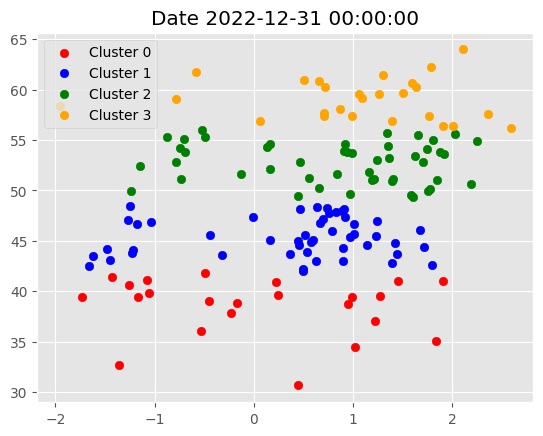

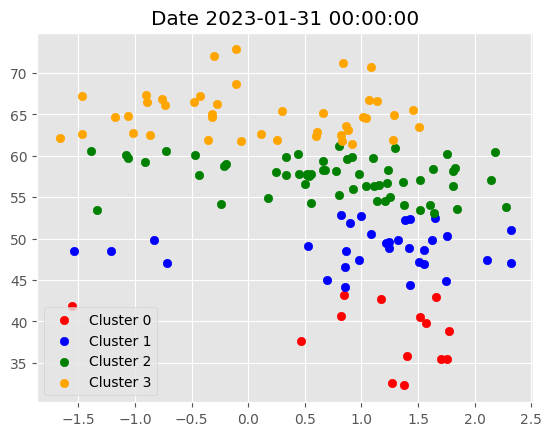

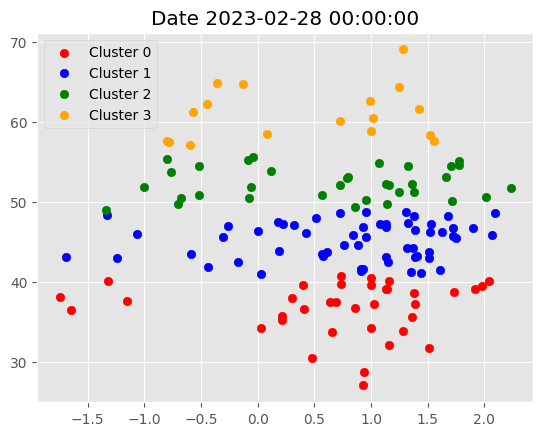

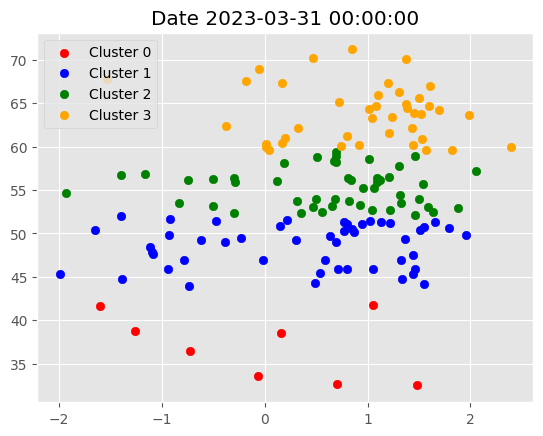

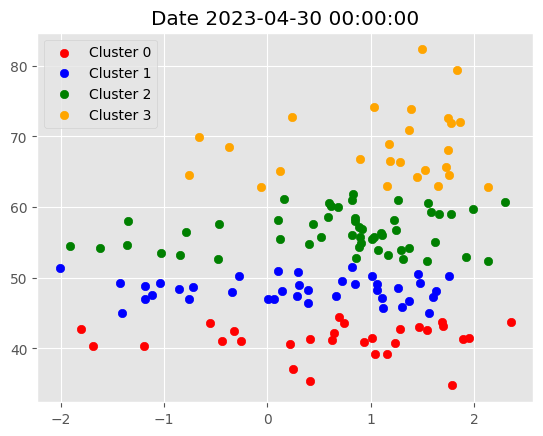

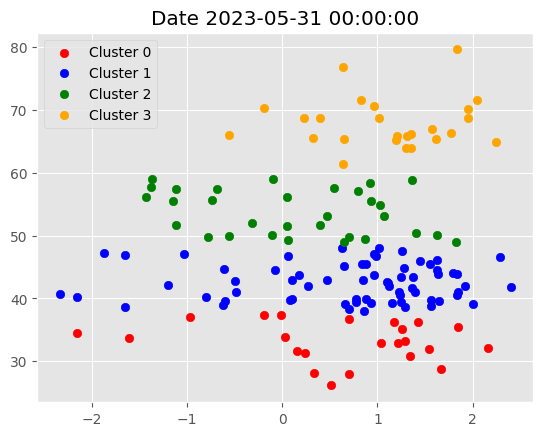

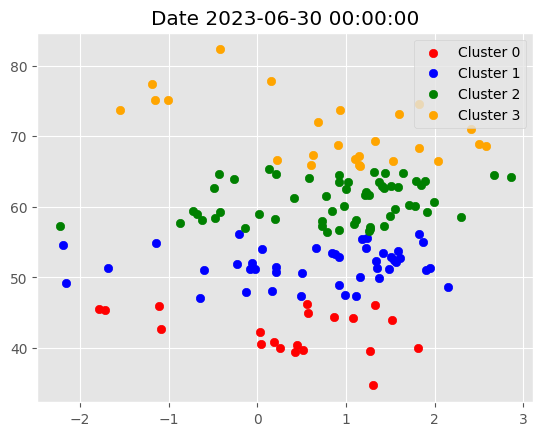

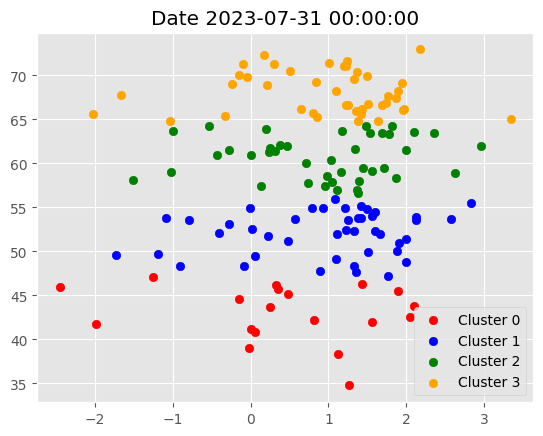

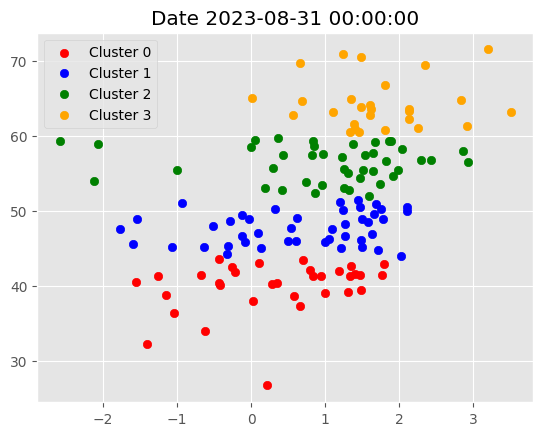

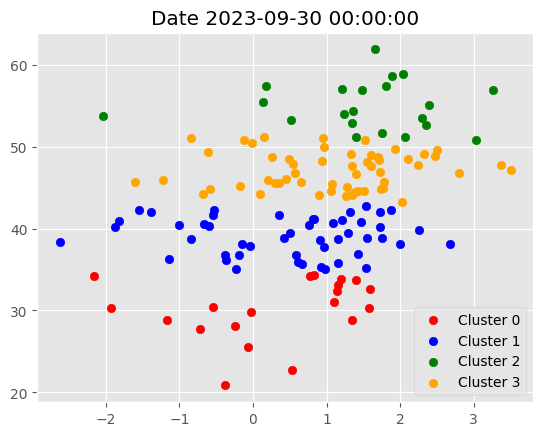

In [107]:
plt.style.use('ggplot')

for i in data_df.index.get_level_values('Date').unique().tolist():
    
    g = data_df.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

### For Each Month Select Assets Based on the Cluster and Form a Portfolio Based on Efficient Frontier Max Sharpe Ratio Optimisation

- First filter only stocks corresponding to the cluster chosen based on the hypothesis.
- Momentum is persistent and the idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus select stocks corresponding to highest RSI cluster.

In [108]:
filtered_df = data_df[data_df['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['Date', 'Ticker'])

dates = filtered_df.index.get_level_values('Date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COF',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MPC',
  'MRO',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AXP',
  'AZO',
  'BA',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'SYF',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'YUM'],
 '2018-01-01': ['ACN',
  'BA',
  'CAT',
  'COF',
  'CSCO',
  'CVX',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'MRO',
  'OXY',
  'PEP',
  'RTX',
  'STZ',
  'SYF',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VTRS',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  '

### Define Portfolio Optimisation Function

- Define a function which optimises portfolio weights using PyPortfolioOpt package and EfficientFrontier optimiser to maximise the sharpe ratio.
- To optimise the weights of a given portfolio the last 1 year prices need to be supplied to the function.
- Apply single stock weight bounds constraints for diversifcation.

In [109]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

Now we want to assign weights to the cluster 3 stocks for each month at the beginning of the next month.

In [122]:
def optimise_weights(prices, lower_bound = 0, upper_bound = 0.1):

    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)

    cov = risk_models.sample_cov(prices=prices, frequency=252)

    ef = EfficientFrontier(expected_returns = returns, 
                           cov_matrix = cov, 
                           weight_bounds=(lower_bound, upper_bound), 
                           solver='SCS')
    
    weights = ef.max_sharpe()

    return ef.clean_weights()

Download fresh daily prices data only for short listed stocks.

In [123]:
stocks = data_df.index.get_level_values('Ticker').unique().tolist()

new_data_df = yf.download(tickers = stocks,
                          start = data_df.index.get_level_values('Date').unique()[0]-pd.DateOffset(months=12),
                          end = data_df.index.get_level_values('Date').unique()[-1])

new_data_df

[*********************100%%**********************]  176 of 176 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABNB        ABT   
Date                                                                   
2016-10-31  39.134331   26.212475   40.245117         NaN  34.293461   
2016-11-01  38.363205   25.739199   40.728531         NaN  34.127403   
2016-11-02  38.276459   25.762289   40.973827         NaN  33.821514   
2016-11-03  38.054203   25.486151   40.324493         NaN  33.541862   
2016-11-04  38.402084   25.256416   40.432720         NaN  34.162376   
...               ...         ...         ...         ...        ...   
2023-09-25  12.910000  175.386337  150.264954  134.139999  95.991318   
2023-09-26  12.700000  171.282562  149.545944  132.279999  94.770126   
2023-09-27  12.610000  169.758591  148.788055  134.029999  94.080750   
2023-09-28  12.920000  170.017578  147.933014  136.470001  96.631462   
2023-09-29  12.810000  170.535538  144.833450  137.210007  95.380714   

Price                                                                   ...  \
Ticker             ACN        ADBE         ADI         ADP        ADSK  ...   
Date                                                                    ...   
2016-10-31  103.569633  107.510002   55.107708   73.831535   72.279999  ...   
2016-11-01  103.480537  106.870003   54.677860   73.712799   70.099998  ...   
2016-11-02  105.681290  105.889999   54.729439   76.307831   68.680000  ...   
2016-11-03  104.202240  107.169998   54.892784   75.756607   67.610001  ...   
2016-11-04  104.451706  106.199997   54.531696   75.544594   69.440002  ...   
...                ...         ...         ...         ...         ...  ...   
2023-09-25  313.318970  511.600006  173.099823  235.844101  205.669998  ...   
2023-09-26  307.012848  506.299988  170.050873  233.112457  201.660004  ...   
2023-09-27  310.739227  502.600006  170.514633  238.408676  202.279999  ...   
2023-09-28  297.286835  504.670013  174.066818  239.076843  207.889999  ...   
2023-09-29  303.553406  509.899994  172.764343  236.394348  206.910004  ...   

Price        Volume                                                   \
Ticker         VRTX      VTRS        VZ       WBA      WDC       WFC   
Date                                                                   
2016-10-31  1928200   5473100  12459400   4662100  3363200  20115900   
2016-11-01  2458200   6488900  13229400   5130800  3821100  20020200   
2016-11-02  2580400   5947000  16488200   9783100  4216200  19566600   
2016-11-03  2371000  17832200  12605100   4586500  3192600  14982700   
2016-11-04  1902100   7932400  14410200   7023900  2705600  27391600   
...             ...       ...       ...       ...      ...       ...   
2023-09-25   698100   5595100  17616900   6891000  2685900  10624000   
2023-09-26   633600   5884000  18841600   7570500  3571100  15219400   
2023-09-27   860600   8614500  22083500  10182900  2547800  11815500   
2023-09-28   578900   8042500  18772100   7291500  3282000  12454600   
2023-09-29   896800   6365500  19759400  25659100  2512000  13119100   

Price                                              
Ticker           WMT     WYNN       XOM       YUM  
Date                                               
2016-10-31  19167000  1341600  16663800   5419197  
2016-11-01  26515800  3722300  13050600  12111800  
2016-11-02  22935900  2542400  11226100  10132900  
2016-11-03  20411700  9050400   8836500   7187800  
2016-11-04  21786300  3223800  13877100   4125200  
...              ...      ...       ...       ...  
2023-09-25  10459500  1387800  11316000   1048500  
2023-09-26  14435700  1454000  11805400   1500600  
2023-09-27  15711000  2050000  23976200   1922300  
2023-09-28  11617200  1290400  16808100   1722700  
2023-09-29  18842400  1326800  18810700   2610000  

[1740 rows x 1056 columns]

- Calculate daily returns for each stiock which could land up in our portoflio.
- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.
- If the maximum sharpe ratio optimisation fails for a given month, apply equally-weighted weights.
- Calculated each day portfolio return.

In [129]:
returns_dataframe = np.log(new_data_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        # Ensure data is selected correctly
        optimization_df = new_data_df.loc[optimization_start_date:optimization_end_date, ('Adj Close', cols)]
        
        try:
            # Optimize weights
            weights_dict = optimise_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2), 3))
            weights = pd.DataFrame(list(weights_dict.items()), columns=['Ticker', 'Weight'])
        except Exception as e:
            print(f'Max Sharpe Optimization failed for {start_date}: {e}')
            # Equal weights as fallback
            weights = pd.DataFrame({'Ticker': cols, 'Weight': [1/len(cols)] * len(cols)})

        # Merge returns with weights
        temp_df = returns_dataframe.loc[start_date:end_date, cols].stack().reset_index()
        temp_df.columns = ['Date', 'Ticker', 'Return']
        temp_df = temp_df.merge(weights, on='Ticker', how='left', validate='many_to_one')

        # Calculate weighted returns
        temp_df['Weighted_Return'] = temp_df['Return'] * temp_df['Weight']
        temp_df = temp_df.groupby('Date')['Weighted_Return'].sum().to_frame('Strategy Return')

        # Append to the main DataFrame
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(f'Error processing {start_date}: {e}')

portfolio_df = portfolio_df.drop_duplicates()
print(portfolio_df)

Max Sharpe Optimization failed for 2018-04-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Max Sharpe Optimization failed for 2018-05-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Max Sharpe Optimization failed for 2019-01-01: at least one of the assets must have an expected return exceeding the risk-free rate
Max Sharpe Optimization failed for 2020-03-01: at least one of the assets must have an expected return exceeding the risk-free rate
Max Sharpe Optimization failed for 2020-04-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Max Sharpe Optimization failed for 2021-02-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Max Sharpe Optimization failed for 2021-10-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasibl

In [130]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
Date                                     
2017-11-01         0.000000      0.001321
2018-04-02        -0.017167     -0.021821
2018-04-03         0.008864      0.012735
2018-04-04         0.004514      0.010643
2018-04-05         0.015766      0.007861
...                     ...           ...
2022-10-25        -0.003867      0.015842
2022-10-26         0.024803     -0.007563
2022-10-27        -0.009171     -0.005354
2022-10-28         0.022842      0.023512
2022-10-31        -0.002994     -0.007250

[190 rows x 2 columns]